# 🧪 Backtest Framework — Colab Mini-MT5 (v1)
**Gerado:** 2025-11-12 22:53:17  
**Objetivo:** ambiente genérico de backtest onde o trader só escreve a **estratégia** e o framework faz o resto (dados → execução → métricas → plots → relatório).

> **Como usar:** Siga os blocos de cima para baixo. No bloco **06_ESTRATEGIA**, escreva/cole sua função `generate_signals(df)`.


## 01 — Instalação & Imports

In [ ]:

# Se estiver no Colab, tudo abaixo já existe. Descomente se precisar instalar algo extra.
!pip -q install pandas numpy matplotlib ta

import os, re, math, uuid, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

pd.set_option('display.max_colwidth', 120)
print('✅ Imports prontos.')


✅ Imports prontos.


## 02 — Configurações Gerais

In [ ]:

CONFIG = {
    'fee_pct'     : 0.0004,   # 0.04% por operação (ida e volta ~0.08%)
    'slippage_pct': 0.0001,   # 0.01% de slippage por execução
    'initial_cap' : 1000.0,   # capital inicial
    'risk_per_trade_pct': 1.0, # % do capital por trade (para sizing por SL)
    'allow_short' : False,     # cripto spot: normalmente False. Em futuros, True.
    'max_positions': 1,        # 1 posição por vez
    'price_col'   : 'close',   # preço usado para execuções
}

print(CONFIG)


{'fee_pct': 0.0004, 'slippage_pct': 0.0001, 'initial_cap': 1000.0, 'risk_per_trade_pct': 1.0, 'allow_short': False, 'max_positions': 1, 'price_col': 'close'}


In [ ]:
# ======================================================
#  BINANCE HTTP LOADER – VERSÃO FINAL UNIFICADA
# ======================================================
import pandas as pd
import requests, zipfile, io
from datetime import datetime, timedelta

# ======================================================
# 1. Normalização do TF (corrige 1H → 1h etc)
# ======================================================
def normalize_tf(tf):
    tf = tf.strip().lower()
    fix = {
        "1h": "1h", "h1": "1h",
        "4h": "4h", "h4": "4h",
        "1d": "1d", "d1": "1d",
        "1m": "1m", "5m": "5m", "15m": "15m", "30m": "30m",
    }
    return fix.get(tf, tf)

# ======================================================
# 2. Downloader (arquivo ZIP mensal correto)
# ======================================================
def download_binance_month(symbol, timeframe, year, month):

    file_name = f"{symbol}-{timeframe}-{year}-{month:02d}.zip"
    url = (
        f"https://data.binance.vision/data/spot/monthly/klines/"
        f"{symbol}/{timeframe}/{file_name}"
    )

    r = requests.get(url)
    if r.status_code != 200:
        print(f"[x] Não existe: {url}")
        return None

    print(f"[OK] Baixado: {url}")

    z = zipfile.ZipFile(io.BytesIO(r.content))
    csv_name = z.namelist()[0]
    df = pd.read_csv(z.open(csv_name), header=None)

    df.columns = [
        "open_time", "open", "high", "low", "close", "volume",
        "close_time", "quote_volume", "trades",
        "taker_buy_base", "taker_buy_quote", "ignore"
    ]

    # FILTRO anti timestamp absurdo (bug da Binance)
    df = df[(df["open_time"] > 0) & (df["open_time"] < 32503680000000)]

    df["datetime"] = pd.to_datetime(df["open_time"], unit="ms")

    return df[["datetime","open","high","low","close","volume"]]

# ======================================================
# 3. VALIDATE_DATA (existia antes, agora está AQUI)
# ======================================================
def validate_data(df, timeframe):
    print("\n============================")
    print("🔍 VALIDANDO CONSISTÊNCIA...")
    print("============================")

    df = df.sort_values("datetime").reset_index(drop=True)

    tf_map = {
        "1m": 1, "5m": 5, "15m": 15, "30m": 30,
        "1h": 60, "4h": 240, "1d": 1440
    }

    size = tf_map.get(timeframe.lower(), 60)
    expected = timedelta(minutes=size)

    df["next"] = df["datetime"].shift(-1)
    df["diff"] = df["next"] - df["datetime"]

    gaps = df[df["diff"] > expected]
    dups = df[df["datetime"].duplicated()]

    print(f"Total candles: {len(df)}")
    print(f"Gaps detectados: {len(gaps)}")
    print(f"Duplicados removidos: {len(dups)}")

    df = df.drop_duplicates(subset="datetime")
    df = df.drop(columns=["next","diff"], errors="ignore")

    return df

# ======================================================
# 4. Loader Principal
# ======================================================
def fetch_binance_http():
    print("=== BINANCE HTTP LOADER FINAL ===")

    symbol = input("Ativo (ex: BTCUSDT): ").strip().upper()
    timeframe = normalize_tf(input("TF (1m,5m,15m,30m,1h,4h,1d): ").strip())

    print("\nPeríodo:")
    print("1 → 1 mês")
    print("2 → 3 meses")
    print("3 → 6 meses")
    print("4 → 1 ano")
    print("5 → 2 anos")
    print("6 → 3 anos")
    print("7 → 5 anos")
    print("8 → TUDO (2017→hoje)")
    choice = int(input("Escolha: "))

    REAL_BINANCE_MAX = datetime(2025, 10, 31)
    now = min(datetime.utcnow(), REAL_BINANCE_MAX)

    periods = {
        1: now - timedelta(days=30),
        2: now - timedelta(days=90),
        3: now - timedelta(days=180),
        4: now - timedelta(days=365),
        5: now - timedelta(days=365*2),
        6: now - timedelta(days=365*3),
        7: now - timedelta(days=365*5),
        8: datetime(2017,1,1)
    }

    start = periods.get(choice, now - timedelta(days=30))

    print(f"[INFO] Baixando {symbol} {timeframe} de {start.date()} até {now.date()}...\n")

    dfs = []
    year = start.year
    month = start.month

    while (year < now.year) or (year == now.year and month <= now.month):

        if year == now.year and month == now.month:
            break

        print(f"Baixando {year}-{month:02d}...")
        dfm = download_binance_month(symbol, timeframe, year, month)

        if dfm is not None:
            dfs.append(dfm)

        month += 1
        if month == 13:
            month = 1
            year += 1

    if not dfs:
        print("[ERRO] Nenhum arquivo encontrado.")
        return None

    full = pd.concat(dfs).sort_values("datetime").reset_index(drop=True)
    print(f"[OK] Candles brutos: {len(full)}")

    clean = validate_data(full, timeframe)
    print(f"[FINAL] Candles limpos: {len(clean)}")

    return clean


# ===================== USO =====================
df_raw = fetch_binance_http()
df_raw.head()


=== BINANCE HTTP LOADER FINAL ===
Ativo (ex: BTCUSDT): BTCUSDT
TF (1m,5m,15m,30m,1h,4h,1d): 1H

Período:
1 → 1 mês
2 → 3 meses
3 → 6 meses
4 → 1 ano
5 → 2 anos
6 → 3 anos
7 → 5 anos
8 → TUDO (2017→hoje)
Escolha: 8
[INFO] Baixando BTCUSDT 1h de 2017-01-01 até 2025-10-31...

Baixando 2017-01...
[x] Não existe: https://data.binance.vision/data/spot/monthly/klines/BTCUSDT/1h/BTCUSDT-1h-2017-01.zip
Baixando 2017-02...
[x] Não existe: https://data.binance.vision/data/spot/monthly/klines/BTCUSDT/1h/BTCUSDT-1h-2017-02.zip
Baixando 2017-03...
[x] Não existe: https://data.binance.vision/data/spot/monthly/klines/BTCUSDT/1h/BTCUSDT-1h-2017-03.zip
Baixando 2017-04...
[x] Não existe: https://data.binance.vision/data/spot/monthly/klines/BTCUSDT/1h/BTCUSDT-1h-2017-04.zip
Baixando 2017-05...
[x] Não existe: https://data.binance.vision/data/spot/monthly/klines/BTCUSDT/1h/BTCUSDT-1h-2017-05.zip
Baixando 2017-06...
[x] Não existe: https://data.binance.vision/data/spot/monthly/klines/BTCUSDT/1h/BTCUSDT-1h-

,datetime,open,high,low,close,volume
0,2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009
1,2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916
2,2017-08-17 06:00:00,4330.29,4345.45,4309.37,4324.35,7.229691
3,2017-08-17 07:00:00,4316.62,4349.99,4287.41,4349.99,4.443249
4,2017-08-17 08:00:00,4333.32,4377.85,4333.32,4360.69,0.972807


In [ ]:
# ========================================================
#  CONSISTENCY VALIDATOR PRO – Estilo Tick Data Suite
# ========================================================
import pandas as pd
import numpy as np

class DataQualitySuite:
    def __init__(self, df: pd.DataFrame, timeframe: str):
        self.df = df.copy()
        self.timeframe = timeframe.lower()
        self.issues = {
            "timestamp_gaps": [],
            "timestamp_duplicates": [],
            "timestamp_out_of_order": [],
            "invalid_candles": [],
            "price_anomalies": [],
            "volume_anomalies": [],
        }

    # -----------------------------------------
    # 1. Calcula o delta esperado entre candles
    # -----------------------------------------
    def _expected_delta(self):
        tf_map = {
            "1m": 1,
            "5m": 5,
            "15m": 15,
            "30m": 30,
            "1h": 60,
            "2h": 120,
            "4h": 240,
            "1d": 1440,
        }
        minutes = tf_map.get(self.timeframe, 60)
        return pd.Timedelta(minutes=minutes)

    # -----------------------------------------
    # 2. Verificar integridade de timestamps
    # -----------------------------------------
    def check_timestamps(self):
        df = self.df.sort_values("datetime").reset_index(drop=True)
        exp = self._expected_delta()

        for i in range(len(df) - 1):
            t1 = df.loc[i, "datetime"]
            t2 = df.loc[i + 1, "datetime"]

            delta = t2 - t1

            # gap
            if delta > exp:
                self.issues["timestamp_gaps"].append((i, t1, t2, delta))

            # fora de ordem
            if delta.total_seconds() < 0:
                self.issues["timestamp_out_of_order"].append((i, t1, t2))

        # duplicados
        dups = df[df["datetime"].duplicated()]["datetime"].tolist()
        self.issues["timestamp_duplicates"] = dups

    # -----------------------------------------
    # 3. Validação interna do candle
    # -----------------------------------------
    def check_candle_integrity(self):
        df = self.df

        for i, row in df.iterrows():
            o, h, l, c = float(row.open), float(row.high), float(row.low), float(row.close)

            # regras essenciais
            if not (l <= o <= h and l <= c <= h):
                self.issues["invalid_candles"].append((i, row.datetime))

            # valores negativos ou absurdos
            if o <= 0 or h <= 0 or l <= 0 or c <= 0:
                self.issues["invalid_candles"].append((i, row.datetime))

            # high < low?
            if h < l:
                self.issues["invalid_candles"].append((i, row.datetime))

    # -----------------------------------------
    # 4. Anomalias de preço (spikes)
    # -----------------------------------------
    def check_price_anomalies(self):
        df = self.df.sort_values("datetime").reset_index(drop=True)

        # variação do candle
        df["range_pct"] = (df["high"] - df["low"]) / df["open"].replace(0, np.nan)

        # spikes absurdos (ex: >20%)
        anomalies = df[df["range_pct"] > 0.20]

        for idx, row in anomalies.iterrows():
            self.issues["price_anomalies"].append(
                (idx, row.datetime, float(row.range_pct))
            )

    # -----------------------------------------
    # 5. Anomalias de volume
    # -----------------------------------------
    def check_volume(self):
        df = self.df

        # volume zero em timeframes > 1m é estranho
        vol_zero = df[df["volume"] == 0]

        for idx, row in vol_zero.iterrows():
            self.issues["volume_anomalies"].append((idx, row.datetime))

        # volume absurdamente alto
        threshold = df["volume"].mean() + 5 * df["volume"].std()
        vol_spikes = df[df["volume"] > threshold]

        for idx, row in vol_spikes.iterrows():
            self.issues["volume_anomalies"].append((idx, row.datetime))

    # -----------------------------------------
    # 6. Rodar tudo
    # -----------------------------------------
    def run(self):
        print("🔍 Executando validação completa...\n")

        self.check_timestamps()
        self.check_candle_integrity()
        self.check_price_anomalies()
        self.check_volume()

        print("✔ Validação concluída.\n")

    # -----------------------------------------
    # 7. Score final (0–100)
    # -----------------------------------------
    def score(self):
        base = 100

        penalties = (
            len(self.issues["timestamp_gaps"]) * 2 +
            len(self.issues["timestamp_duplicates"]) * 2 +
            len(self.issues["timestamp_out_of_order"]) * 3 +
            len(self.issues["invalid_candles"]) * 4 +
            len(self.issues["price_anomalies"]) * 1 +
            len(self.issues["volume_anomalies"]) * 1
        )

        return max(0, base - penalties)

    # -----------------------------------------
    # 8. Relatório completo
    # -----------------------------------------
    def report(self):
        print("=====================================")
        print("📊 RELATÓRIO FINAL DE CONSISTÊNCIA")
        print("=====================================\n")

        for issue_type, items in self.issues.items():
            print(f"{issue_type}: {len(items)}")

        print("\n-------------------------------------")
        print(f"⭐ SCORE FINAL DA QUALIDADE: {self.score()}/100")
        print("-------------------------------------")

        if self.score() >= 95:
            print("✔ Qualidade EXCELENTE")
        elif self.score() >= 85:
            print("✔ Qualidade MUITO BOA")
        elif self.score() >= 70:
            print("⚠ Qualidade RAZOÁVEL")
        else:
            print("❌ Qualidade RUIM — precisa corrigir\n")

validator = DataQualitySuite(df_raw, timeframe="1h")
validator.run()
validator.report()


🔍 Executando validação completa...

✔ Validação concluída.

📊 RELATÓRIO FINAL DE CONSISTÊNCIA

timestamp_gaps: 28
timestamp_duplicates: 0
timestamp_out_of_order: 0
invalid_candles: 0
price_anomalies: 5
volume_anomalies: 441

-------------------------------------
⭐ SCORE FINAL DA QUALIDADE: 0/100
-------------------------------------
❌ Qualidade RUIM — precisa corrigir



In [ ]:
# =========================================================
#   INDICATORS PACK — "MT5 Style"
#   Funções de indicadores que recebem df e devolvem df
# =========================================================

import numpy as np
import pandas as pd

# -------------------------------------------
# Helpers
# -------------------------------------------
def _ensure_datetime_index(df):
    df = df.copy()
    if "datetime" in df.columns:
        df["datetime"] = pd.to_datetime(df["datetime"])
    return df

# -------------------------------------------
# SMA — Simple Moving Average
# -------------------------------------------
def add_sma(df, period=20, col="close", name=None):
    df = df.copy()
    if name is None:
        name = f"sma{period}"
    df[name] = df[col].rolling(period).mean()
    return df

# -------------------------------------------
# EMA — Exponential Moving Average
# -------------------------------------------
def add_ema(df, period=20, col="close", name=None):
    df = df.copy()
    if name is None:
        name = f"ema{period}"
    df[name] = df[col].ewm(span=period, adjust=False).mean()
    return df

# -------------------------------------------
# RSI — Relative Strength Index
# -------------------------------------------
def add_rsi(df, period=14, col="close", name="rsi"):
    df = df.copy()
    delta = df[col].diff()

    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)

    avg_gain = gain.rolling(period).mean()
    avg_loss = loss.rolling(period).mean()

    rs = avg_gain / avg_loss
    df[name] = 100 - (100 / (1 + rs))
    return df

# -------------------------------------------
# ATR — Average True Range
# -------------------------------------------
def add_atr(df, period=14, name="atr"):
    df = df.copy()
    high = df["high"]
    low  = df["low"]
    close_prev = df["close"].shift(1)

    tr1 = high - low
    tr2 = (high - close_prev).abs()
    tr3 = (low  - close_prev).abs()

    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    df["tr"] = tr
    df[name] = tr.rolling(period).mean()
    return df

# -------------------------------------------
# ADX — Average Directional Index
# -------------------------------------------
def add_adx(df, period=14, name="adx"):
    df = df.copy()
    high = df["high"]
    low  = df["low"]
    close_prev = df["close"].shift(1)

    # True Range
    tr1 = high - low
    tr2 = (high - close_prev).abs()
    tr3 = (low  - close_prev).abs()
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

    # +DM / -DM
    plus_dm  = (high - high.shift(1)).where( (high - high.shift(1)) > (low.shift(1) - low), 0.0 )
    plus_dm  = plus_dm.where(plus_dm > 0, 0.0)

    minus_dm = (low.shift(1) - low).where( (low.shift(1) - low) > (high - high.shift(1)), 0.0 )
    minus_dm = minus_dm.where(minus_dm > 0, 0.0)

    tr_n     = tr.rolling(period).sum()
    plus_di  = 100 * (plus_dm.rolling(period).sum()  / tr_n)
    minus_di = 100 * (minus_dm.rolling(period).sum() / tr_n)

    dx = ( (plus_di - minus_di).abs() / (plus_di + minus_di).replace(0, np.nan) ) * 100
    adx = dx.rolling(period).mean()

    df["plus_di"]  = plus_di
    df["minus_di"] = minus_di
    df[name] = adx
    return df

# -------------------------------------------
# MACD — Moving Average Convergence Divergence
# -------------------------------------------
def add_macd(df, fast=12, slow=26, signal=9,
             col="close",
             name_macd="macd",
             name_signal="macd_signal",
             name_hist="macd_hist"):
    df = df.copy()
    ema_fast = df[col].ewm(span=fast, adjust=False).mean()
    ema_slow = df[col].ewm(span=slow, adjust=False).mean()

    macd = ema_fast - ema_slow
    macd_signal = macd.ewm(span=signal, adjust=False).mean()
    macd_hist = macd - macd_signal

    df[name_macd]   = macd
    df[name_signal] = macd_signal
    df[name_hist]   = macd_hist
    return df

# -------------------------------------------
# Bollinger Bands
# -------------------------------------------
def add_bbands(df, period=20, std_mult=2,
               col="close",
               name_mid="bb_mid",
               name_up="bb_up",
               name_low="bb_low"):
    df = df.copy()
    ma = df[col].rolling(period).mean()
    std = df[col].rolling(period).std()

    df[name_mid] = ma
    df[name_up]  = ma + std_mult * std
    df[name_low] = ma - std_mult * std
    return df

# -------------------------------------------
# Stochastic Oscillator (%K, %D)
# -------------------------------------------
def add_stochastic(df, k_period=14, d_period=3,
                   name_k="stoch_k",
                   name_d="stoch_d"):
    df = df.copy()
    low_min  = df["low"].rolling(k_period).min()
    high_max = df["high"].rolling(k_period).max()

    stoch_k = 100 * (df["close"] - low_min) / (high_max - low_min)
    stoch_d = stoch_k.rolling(d_period).mean()

    df[name_k] = stoch_k
    df[name_d] = stoch_d
    return df

# -------------------------------------------
# VWAP — Volume Weighted Average Price
# -------------------------------------------
def add_vwap(df, name="vwap"):
    df = df.copy()
    typical_price = (df["high"] + df["low"] + df["close"]) / 3
    cum_tp_vol = (typical_price * df["volume"]).cumsum()
    cum_vol = df["volume"].cumsum()
    df[name] = cum_tp_vol / cum_vol.replace(0, np.nan)
    return df

# -------------------------------------------
# SuperTrend (simplificado)
# -------------------------------------------
def add_supertrend(df, period=10, multiplier=3, name="supertrend"):
    """
    SuperTrend simples baseado em ATR.
    Marca linha de tendência; valores >0 podem representar tendência de alta.
    """
    df = add_atr(df, period=period)  # garante coluna 'atr'
    df = df.copy()

    hl2 = (df["high"] + df["low"]) / 2
    basic_ub = hl2 + multiplier * df["atr"]
    basic_lb = hl2 - multiplier * df["atr"]

    final_ub = basic_ub.copy()
    final_lb = basic_lb.copy()

    for i in range(1, len(df)):
        if (final_ub.iloc[i] > final_ub.iloc[i-1]) or (df["close"].iloc[i-1] > final_ub.iloc[i]):
            final_ub.iloc[i] = final_ub.iloc[i-1]
        if (final_lb.iloc[i] < final_lb.iloc[i-1]) or (df["close"].iloc[i-1] < final_lb.iloc[i]):
            final_lb.iloc[i] = final_lb.iloc[i-1]

    supertrend = pd.Series(index=df.index, dtype=float)
    for i in range(len(df)):
        if i == 0:
            supertrend.iloc[i] = final_ub.iloc[i]
        else:
            if (supertrend.iloc[i-1] == final_ub.iloc[i-1]) and (df["close"].iloc[i] <= final_ub.iloc[i]):
                supertrend.iloc[i] = final_ub.iloc[i]
            elif (supertrend.iloc[i-1] == final_ub.iloc[i-1]) and (df["close"].iloc[i] > final_ub.iloc[i]):
                supertrend.iloc[i] = final_lb.iloc[i]
            elif (supertrend.iloc[i-1] == final_lb.iloc[i-1]) and (df["close"].iloc[i] >= final_lb.iloc[i]):
                supertrend.iloc[i] = final_lb.iloc[i]
            elif (supertrend.iloc[i-1] == final_lb.iloc[i-1]) and (df["close"].iloc[i] < final_lb.iloc[i]):
                supertrend.iloc[i] = final_ub.iloc[i]

    df[name] = supertrend
    return df

# -------------------------------------------
# PACOTE BÁSICO (igual "EA simples" chamando indicadores)
# -------------------------------------------
def add_basic_indicators(df):
    """
    Adiciona um conjunto padrão de indicadores:
    - ema9, ema21
    - rsi14
    - atr14
    - macd(12,26,9)
    - bollinger 20/2
    """
    df = _ensure_datetime_index(df)
    df = add_ema(df, 9,  name="ema9")
    df = add_ema(df, 21, name="ema21")
    df = add_rsi(df, 14, name="rsi14")
    df = add_atr(df, 14, name="atr14")
    df = add_macd(df)  # nomes padrão: macd, macd_signal, macd_hist
    df = add_bbands(df, 20, 2)
    return df

df_raw = add_atr(df_raw)

# ======================================================
# APLICAR INDICADORES PADRÃO NO DF PRINCIPAL
# ======================================================
df_raw = add_basic_indicators(df_raw)
df = df_raw.copy()
print("✅ Indicadores adicionados ao df/df_raw:",
      [c for c in df.columns if c.startswith(("ema", "rsi", "atr", "macd", "bb_"))])



✅ Indicadores adicionados ao df/df_raw: ['atr', 'ema9', 'ema21', 'rsi14', 'atr14', 'macd', 'macd_signal', 'macd_hist', 'bb_mid', 'bb_up', 'bb_low']


## 04 — Utilitários: Drawdown & Métricas

In [ ]:

def equity_curve(pnl_series: pd.Series, initial_cap: float) -> pd.Series:
    return initial_cap + pnl_series.cumsum()

def compute_drawdown(equity: pd.Series) -> pd.DataFrame:
    roll_max = equity.cummax()
    dd = equity / roll_max - 1.0
    return pd.DataFrame({'equity': equity, 'roll_max': roll_max, 'drawdown': dd})

def performance_summary(trades: pd.DataFrame, initial_cap: float) -> dict:
    if trades.empty:
        return {
            'initial_capital': initial_cap,
            'final_balance'  : initial_cap,
            'net_profit'     : 0.0, 'trades': 0,
            'wins': 0, 'losses': 0, 'win_rate_pct': 0.0,
            'gross_profit'   : 0.0, 'gross_loss': 0.0,
            'profit_factor'  : 0.0, 'max_drawdown_pct': 0.0
        }
    final_balance = initial_cap + trades['pnl'].sum()
    wins = (trades['pnl'] > 0).sum()
    losses = (trades['pnl'] <= 0).sum()
    gross_profit = trades.loc[trades['pnl'] > 0, 'pnl'].sum()
    gross_loss   = trades.loc[trades['pnl'] <= 0, 'pnl'].sum()
    win_rate = 100.0 * wins / max(1, len(trades))
    profit_factor = (gross_profit / abs(gross_loss)) if gross_loss < 0 else np.inf

    eq = equity_curve(trades['pnl'], initial_cap)
    dd_df = compute_drawdown(eq)
    max_dd = dd_df['drawdown'].min() * 100.0

    return {
        'initial_capital': round(initial_cap, 2),
        'final_balance'  : round(final_balance, 2),
        'net_profit'     : round(final_balance - initial_cap, 2),
        'trades'         : int(len(trades)),
        'wins'           : int(wins),
        'losses'         : int(losses),
        'win_rate_pct'   : round(win_rate, 2),
        'gross_profit'   : round(gross_profit, 2),
        'gross_loss'     : round(gross_loss, 2),
        'profit_factor'  : round(profit_factor, 2) if np.isfinite(profit_factor) else np.inf,
        'max_drawdown_pct': round(max_dd, 2),
    }

print('✅ Utils prontos.')


✅ Utils prontos.


## 06 — **Estratégia** (você edita aqui)
Escreva sua função `generate_signals(df)` abaixo.

In [ ]:
def generate_signals(df: pd.DataFrame):
    df = df.copy()
    df["datetime"] = pd.to_datetime(df["datetime"])

    indicadores_usados = ["ema9", "ema21"]

    if "ema9" not in df.columns:
        df["ema9"] = df["close"].ewm(span=9, adjust=False).mean()

    if "ema21" not in df.columns:
        df["ema21"] = df["close"].ewm(span=21, adjust=False).mean()

    fast = df["ema9"]
    slow = df["ema21"]

    prev_fast = fast.shift(1)
    prev_slow = slow.shift(1)

    buy_signal  = (prev_fast <= prev_slow) & (fast > slow)
    sell_signal = (prev_fast >= prev_slow) & (fast < slow)

    signals = pd.DataFrame({
        "datetime": df["datetime"],
        "signal": 0
    })

    signals.loc[buy_signal,  "signal"] = 1
    signals.loc[sell_signal, "signal"] = -1

    return signals, indicadores_usados

signals, indicadores_usados = generate_signals(df_raw)


## 05 — Motor de Backtest (genérico, 1 posição por vez)

In [ ]:
# ============================================================
# BACKTESTER PRO UNIVERSAL
# - Suporta:
#   * single_position_mode (True = só 1 trade; False = hedge)
#   * SL/TP opcionais (se a estratégia mandar)
#   * trailing_distance opcional (em preço)
#   * sinais simples (apenas datetime/signal) ou ricos (com colunas extras)
# ============================================================

class Backtester:
    def __init__(self, df: pd.DataFrame, config: dict = None):
        self.df = df.copy().reset_index(drop=True)
        self.df["datetime"] = pd.to_datetime(self.df["datetime"])

        self.config = config or {}
        self.initial_capital      = float(self.config.get("initial_capital", 1000.0))
        self.single_position_mode = bool(self.config.get("single_position_mode", True))
        self.commission_perc      = float(self.config.get("commission_perc", 0.0))  # % do valor nocional
        self.slippage             = float(self.config.get("slippage", 0.0))        # fração do preço (0.0001 = 0.01%)

    # --------------------------------------------------------
    # Função principal de backtest
    # --------------------------------------------------------
    def run(self, signals: pd.DataFrame) -> pd.DataFrame:
        if signals is None or signals.empty:
            print("⚠ Signals vazio. Nada a rodar.")
            return pd.DataFrame()

        sig = signals.copy()
        sig["datetime"] = pd.to_datetime(sig["datetime"])

        # join por datetime (garante alinhamento)
        data = pd.merge(
            self.df,
            sig,
            on="datetime",
            how="left",
            suffixes=("", "_sig")
        )

        # se não tiver coluna signal, assume 0
        if "signal" not in data.columns:
            data["signal"] = 0
        data["signal"] = data["signal"].fillna(0).astype(int)

        # flags de colunas extras (opcionais)
        has_stop   = "stop_price" in data.columns
        has_take   = "take_price" in data.columns
        has_size   = "size" in data.columns
        has_risk   = "risk" in data.columns
        has_trail  = "trailing_distance" in data.columns

        open_trades = []
        closed_trades = []
        trade_id = 0

        # loop candle a candle
        for bar_index, row in enumerate(data.itertuples()):
            dt   = row.datetime
            o    = row.open
            h    = row.high
            l    = row.low
            c    = row.close
            vol  = row.volume
            sigv = row.signal

            # 1) Atualizar trades abertos (MFE/MAE, SL/TP, trailing)
            still_open = []
            for t in open_trades:
                direction = t["direction"]
                size      = t["size"]
                entry_px  = t["entry_price"]

                # --------- MFE / MAE (em dinheiro) ---------
                if direction == "long":
                    best_pnl  = (h - entry_px) * size
                    worst_pnl = (l - entry_px) * size
                else:  # short
                    best_pnl  = (entry_px - l) * size
                    worst_pnl = (entry_px - h) * size

                t["max_favor"]  = max(t["max_favor"], best_pnl)
                t["max_adverse"] = min(t["max_adverse"], worst_pnl)

                exit_reason = None
                exit_price  = None

                # --------- Trailing Stop (opcional) ---------
                if t.get("trailing_distance") is not None:
                    dist = t["trailing_distance"]
                    if direction == "long":
                        new_stop = c - dist
                        if t["stop_price"] is None or np.isnan(t["stop_price"]):
                            t["stop_price"] = new_stop
                        else:
                            t["stop_price"] = max(t["stop_price"], new_stop)
                    else:
                        new_stop = c + dist
                        if t["stop_price"] is None or np.isnan(t["stop_price"]):
                            t["stop_price"] = new_stop
                        else:
                            t["stop_price"] = min(t["stop_price"], new_stop)

                # --------- Checar SL / TP (se existirem) ---------
                sp = t.get("stop_price", None)
                tp = t.get("take_price", None)

                hit_sl = False
                hit_tp = False

                if direction == "long":
                    if sp is not None and not pd.isna(sp) and l <= sp:
                        hit_sl = True
                    if tp is not None and not pd.isna(tp) and h >= tp:
                        hit_tp = True
                else:
                    if sp is not None and not pd.isna(sp) and h >= sp:
                        hit_sl = True
                    if tp is not None and not pd.isna(tp) and l <= tp:
                        hit_tp = True

                if hit_sl or hit_tp:
                    # prioriza SL (abordagem conservadora)
                    if hit_sl:
                        exit_price  = sp
                        exit_reason = "sl"
                    else:
                        exit_price  = tp
                        exit_reason = "tp"

                # --------- Fechamento por SL/TP ---------
                if exit_reason is not None:
                    self._close_trade(
                        t, exit_price, dt, bar_index,
                        exit_reason=exit_reason
                    )
                    closed_trades.append(t)
                else:
                    still_open.append(t)

            open_trades = still_open

            # 2) Fechamento por sinal (apenas no modo "single position")
            if self.single_position_mode and sigv != 0 and len(open_trades) > 0:
                # fecha trade atual pelo sinal oposto e abre outro (se quiser)
                new_direction = "long" if sigv > 0 else "short"
                updated = []
                for t in open_trades:
                    # fecha todos – modo "apenas 1 posição"
                    self._close_trade(
                        t, c, dt, bar_index,
                        exit_reason="signal"
                    )
                    closed_trades.append(t)
                open_trades = []

                # abre nova posição seguindo o sinal
                if sigv != 0:
                    new_trade = self._open_trade_from_row(
                        trade_id, dt, c, vol, bar_index,
                        sig_row=row,
                        has_stop=has_stop,
                        has_take=has_take,
                        has_size=has_size,
                        has_risk=has_risk,
                        has_trail=has_trail
                    )
                    if new_trade is not None:
                        open_trades.append(new_trade)
                        trade_id += 1

            # 3) Abertura de trades por sinal (modo hedge OU se não há nenhum aberto)
            else:
                if sigv != 0:
                    # no modo single, só abre se não há trade aberto
                    if self.single_position_mode and len(open_trades) > 0:
                        pass  # já tratamos no bloco anterior
                    else:
                        new_trade = self._open_trade_from_row(
                            trade_id, dt, c, vol, bar_index,
                            sig_row=row,
                            has_stop=has_stop,
                            has_take=has_take,
                            has_size=has_size,
                            has_risk=has_risk,
                            has_trail=has_trail
                        )
                        if new_trade is not None:
                            open_trades.append(new_trade)
                            trade_id += 1

        # 4) Fecha o que sobrou no último candle (EOD)
        if len(open_trades) > 0:
            last_row = data.iloc[-1]
            last_dt  = last_row["datetime"]
            last_c   = last_row["close"]
            last_idx = len(data) - 1
            for t in open_trades:
                self._close_trade(
                    t, last_c, last_dt, last_idx,
                    exit_reason="eod"
                )
                closed_trades.append(t)

        if not closed_trades:
            print("⚠ Nenhum trade fechado.")
            return pd.DataFrame()

        trades_df = pd.DataFrame(closed_trades)

        # duration & result & R:R
        trades_df["duration"] = trades_df["exit_time"] - trades_df["entry_time"]
        trades_df["bars_in_trade"] = trades_df["exit_bar_index"] - trades_df["entry_bar_index"]

        # resultado textual
        trades_df["result"] = np.where(
            trades_df["pnl"] > 0, "win",
            np.where(trades_df["pnl"] < 0, "loss", "be")
        )

        # ============= PATCH CRÍTICO =============
        # risk pode ser None → nunca usar abs(None)
        if "risk" not in trades_df.columns:
            trades_df["risk"] = np.nan

        trades_df["risk"] = trades_df["risk"].astype(float)

        # Risk:Reward seguro
        trades_df["risk_reward"] = np.where(
            trades_df["risk"].notna() & (trades_df["risk"] != 0),
            trades_df["pnl"] / trades_df["risk"],
            np.nan
        )

        return trades_df

    # --------------------------------------------------------
    # Abre um trade a partir de um sinal (linha de signals + df)
    # --------------------------------------------------------
    def _open_trade_from_row(
        self, trade_id, dt, price, vol, bar_index,
        sig_row,
        has_stop, has_take, has_size, has_risk, has_trail
    ):
        sigv = sig_row.signal
        if sigv == 0:
            return None

        direction = "long" if sigv > 0 else "short"
        size = float(getattr(sig_row, "size", 1.0)) if has_size else 1.0

        stop_price = getattr(sig_row, "stop_price", None) if has_stop else None
        take_price = getattr(sig_row, "take_price", None) if has_take else None
        trailing_distance = getattr(sig_row, "trailing_distance", None) if has_trail else None
        risk = getattr(sig_row, "risk", None) if has_risk else None

        # converte None/nan
        if stop_price is not None and pd.isna(stop_price):
            stop_price = None
        if take_price is not None and pd.isna(take_price):
            take_price = None
        if trailing_distance is not None and pd.isna(trailing_distance):
            trailing_distance = None
        if risk is not None and pd.isna(risk):
            risk = None

        # se a estratégia não definiu risk, tenta inferir pelo SL
        if risk is None and stop_price is not None:
            risk = abs(price - stop_price) * size

        # aplica slippage e comissão na ENTRADA (ajuste leve)
        dir_factor = 1 if direction == "long" else -1
        entry_px = price * (1 + dir_factor * self.slippage)
        commission_open = self.commission_perc * entry_px * size

        trade = {
            "id": trade_id,
            "direction": direction,
            "entry_time": dt,
            "entry_bar_index": bar_index,
            "entry_price": entry_px,
            "size": size,
            "stop_price": stop_price,
            "take_price": take_price,
            "trailing_distance": trailing_distance,
            "risk": risk,
            "max_favor": 0.0,
            "max_adverse": 0.0,
            "volume_at_entry": vol,
            "exit_time": None,
            "exit_bar_index": None,
            "exit_price": None,
            "pnl": None,
            "commission_open": commission_open,
            "commission_close": 0.0,
            "exit_reason": None,
        }
        return trade

    # --------------------------------------------------------
    # Fecha trade (cálculo de PnL, comissão, etc.)
    # --------------------------------------------------------
    def _close_trade(self, trade, exit_price, exit_time, exit_bar_index, exit_reason="unknown"):
        direction = trade["direction"]
        size      = trade["size"]
        dir_factor = 1 if direction == "long" else -1

        # slippage na saída
        px = exit_price * (1 - dir_factor * self.slippage)

        commission_close = self.commission_perc * px * size

        gross_pnl = (px - trade["entry_price"]) * size * dir_factor
        net_pnl = gross_pnl - trade.get("commission_open", 0.0) - commission_close

        trade["exit_time"]      = exit_time
        trade["exit_bar_index"] = exit_bar_index
        trade["exit_price"]     = px
        trade["commission_close"] = commission_close
        trade["pnl"]            = net_pnl
        trade["exit_reason"]    = exit_reason

bt = Backtester(df_raw)
trades = bt.run(signals)

## 07 — Relatórios e Gráficos

In [ ]:

def show_metrics(trades_df: pd.DataFrame, initial_cap: float):
    m = performance_summary(trades_df, initial_cap)
    order = [
        "initial_capital", "final_balance", "net_profit",
        "trades", "wins", "losses", "win_rate_pct",
        "gross_profit", "gross_loss", "profit_factor",
        "max_drawdown_pct"
    ]
    labels = {
        "initial_capital": "Capital Inicial",
        "final_balance": "Saldo Final",
        "net_profit": "Resultado Líquido",
        "trades": "Nº de Trades",
        "wins": "Vitórias",
        "losses": "Derrotas",
        "win_rate_pct": "Taxa de Acerto (%)",
        "gross_profit": "Lucro Bruto",
        "gross_loss": "Prejuízo Bruto",
        "profit_factor": "Profit Factor",
        "max_drawdown_pct": "Max Drawdown (%)",
    }
    df = pd.DataFrame(
        {"Métrica": [labels[k] for k in order],
         "Valor":   [m[k] for k in order]}
    )
    display(df)

def plot_equity(trades_df: pd.DataFrame, initial_cap: float):
    if trades_df.empty:
        print('Sem trades para plotar equity.')
        return
    eq = initial_cap + trades_df['pnl'].cumsum()
    plt.figure()
    plt.plot(eq.index, eq.values)
    plt.title('Equity Curve')
    plt.xlabel('Trade #')
    plt.ylabel('Equity')
    plt.show()

def plot_drawdown(trades_df: pd.DataFrame, initial_cap: float):
    if trades_df.empty:
        print('Sem trades para plotar drawdown.')
        return
    eq = initial_cap + trades_df['pnl'].cumsum()
    dd = compute_drawdown(eq)['drawdown'] * 100.0
    plt.figure()
    plt.plot(dd.index, dd.values)
    plt.title('Drawdown (%)')
    plt.xlabel('Trade #')
    plt.ylabel('DD %')
    plt.show()

print('✅ Relatórios e plots prontos.')


✅ Relatórios e plots prontos.


## 08 — Runner (carrega dados → gera sinais → roda backtest → mostra resultados)

🟩 Gerando gráfico minimalista com volume...


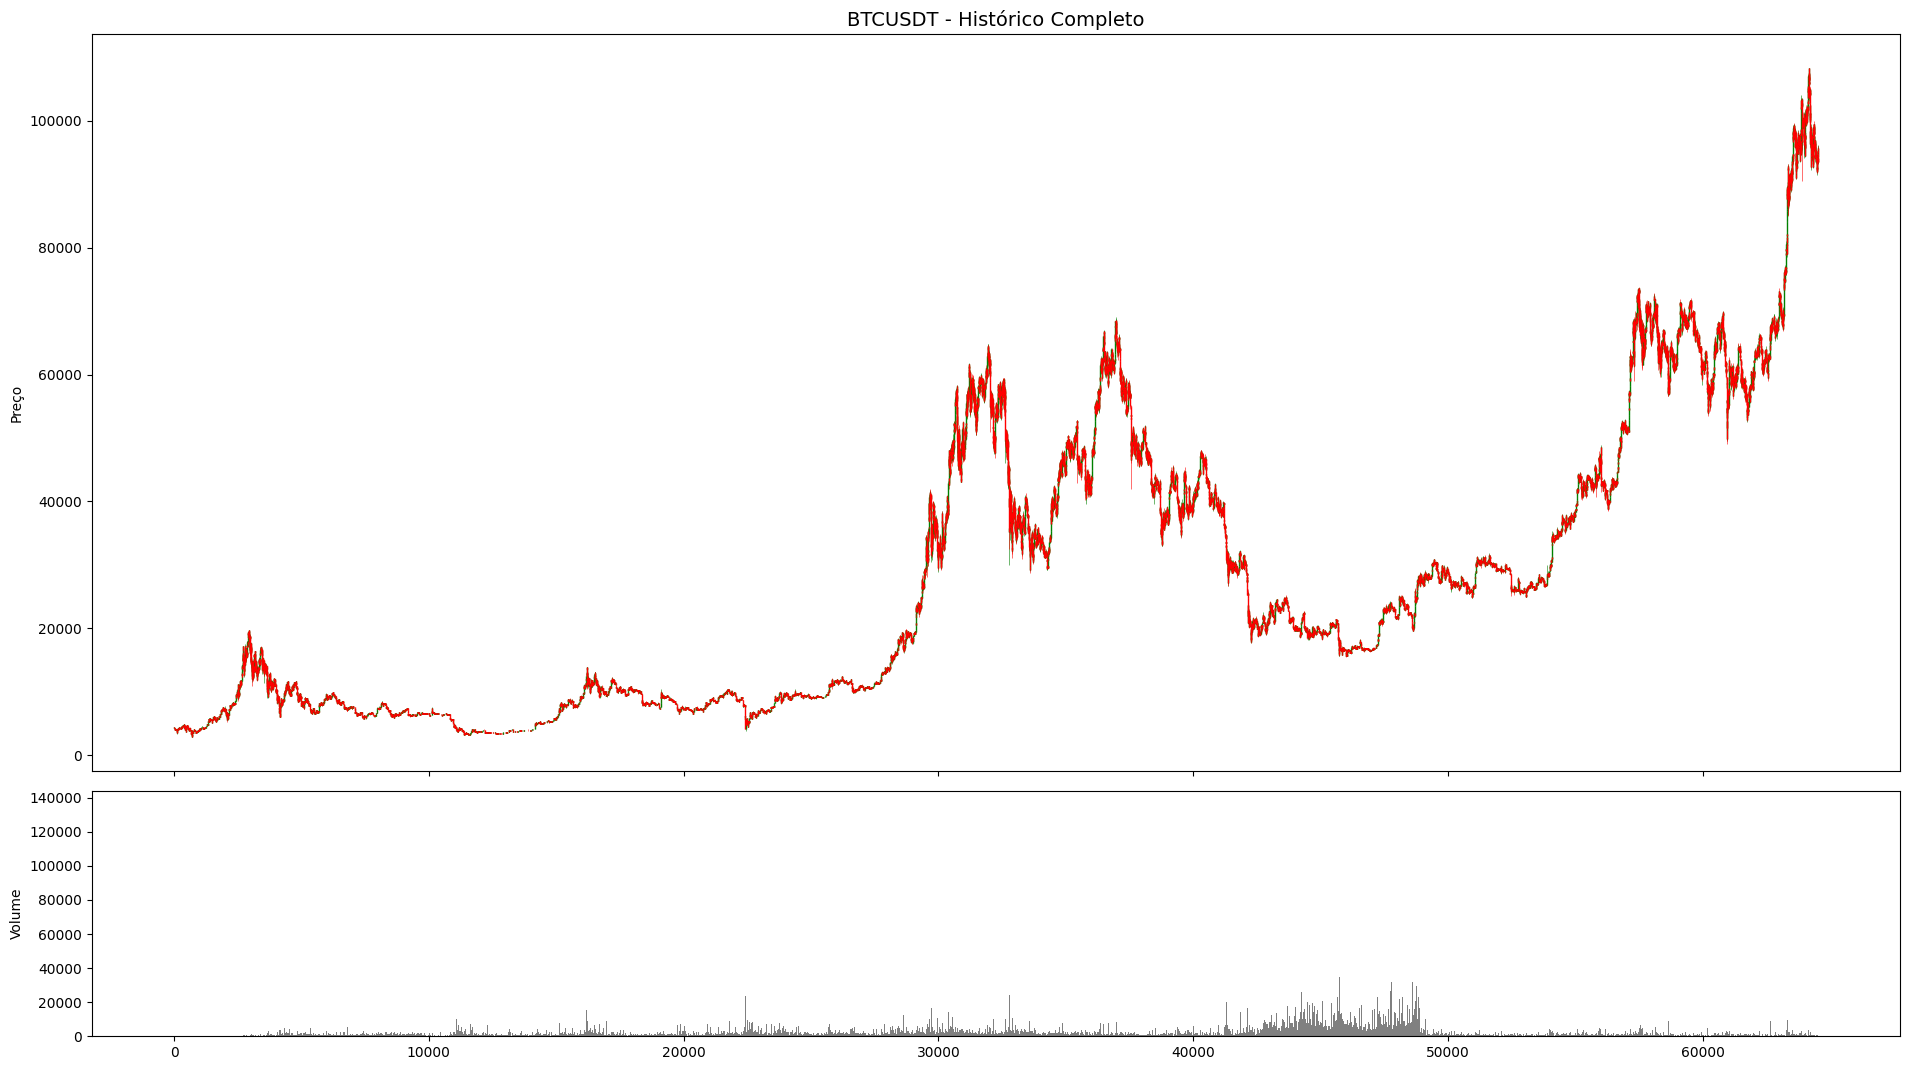

✔ Gráfico pronto!



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_candles_minimal(df, title="Candles + Volume", figsize=(19.2, 10.8)):
    """
    Gráfico minimalista com:
    - Candles em cima
    - Volume embaixo
    - Sem frescura, focado em performance
    """

    print("🟩 Gerando gráfico minimalista com volume...")

    data = df.copy()
    data.index = pd.to_datetime(data["datetime"])

    opens  = data["open"].values
    highs  = data["high"].values
    lows   = data["low"].values
    closes = data["close"].values
    vols   = data["volume"].values

    x = np.arange(len(data))

    # Figura com 2 subplots (preço + volume)
    fig, (ax_price, ax_vol) = plt.subplots(
        2, 1,
        figsize=figsize,
        sharex=True,
        gridspec_kw={'height_ratios': [3, 1]}
    )

    # ------- PREÇO (CANDLES) -------
    up = closes >= opens
    down = closes < opens

    # Pavios
    ax_price.vlines(x[up], lows[up], highs[up], color="green", linewidth=0.4)
    ax_price.vlines(x[down], lows[down], highs[down], color="red", linewidth=0.4)

    # Corpo dos candles
    ax_price.vlines(x[up], opens[up], closes[up], color="green", linewidth=1.0)
    ax_price.vlines(x[down], opens[down], closes[down], color="red", linewidth=1.0)

    ax_price.set_title(title, fontsize=14)
    ax_price.set_ylabel("Preço")
    ax_price.grid(False)

    # ------- VOLUME -------
    ax_vol.bar(x, vols, width=1.0, color="gray")
    ax_vol.set_ylabel("Volume")
    ax_vol.grid(False)

    # Deixa o layout apertado pra caber tudo
    plt.tight_layout()
    plt.show()

    print("✔ Gráfico pronto!\n")


df = df_raw.copy()  # só pra manter compatibilidade com blocos antigos
plot_candles_minimal(df, "BTCUSDT - Histórico Completo")


In [ ]:
# ====================================================
#   BLOCOS DE TRADES — SEGURO E SEM ERROS
# ====================================================

print("===== LISTA COMPLETA DE TRADES =====")

# 1) Garantir que 'trades' existe
if "trades" not in globals():
    print("⚠ Variável 'trades' não existe. Rode o backtest primeiro.")
else:

    # 2) Garantir que é DataFrame
    if trades is None:
        print("⚠ 'trades' está vazio (None).")
    elif not isinstance(trades, pd.DataFrame):
        print("⚠ 'trades' não é um DataFrame. Tipo atual:", type(trades))
    elif trades.empty:
        print("⚠ Nenhum trade encontrado.")
    else:
        display(trades)


print("\n===== RESUMO - ÚLTIMOS TRADES =====")

if "trades" in globals() and isinstance(trades, pd.DataFrame) and not trades.empty:
    display(trades.tail(10))
else:
    print("⚠ Nada para exibir.")


# ====================================================
#  EXPORTAR TRADES PARA CSV (SEGURANÇA TOTAL)
# ====================================================

print("\n===== EXPORTANDO TRADES =====")

if "trades" not in globals():
    print("⚠ Variável 'trades' não existe. Nenhum arquivo será salvo.")
elif trades is None:
    print("⚠ 'trades' é None. Nenhum arquivo será salvo.")
elif not isinstance(trades, pd.DataFrame):
    print("⚠ 'trades' não é DataFrame. Tipo:", type(trades))
elif trades.empty:
    print("⚠ Nenhum trade para exportar.")
else:
    export_path = "/content/trades_resultados.csv"
    trades.to_csv(export_path, index=False)
    print(f"📁 Arquivo salvo com sucesso: {export_path}")


===== LISTA COMPLETA DE TRADES =====


,id,direction,entry_time,entry_bar_index,entry_price,size,stop_price,take_price,trailing_distance,risk,...,exit_bar_index,exit_price,pnl,commission_open,commission_close,exit_reason,duration,bars_in_trade,result,risk_reward
0,0,long,2017-08-17 05:00:00,1,4315.32,1.0,None,None,None,NaN,...,14,4256.97,-58.35,0.0,0.0,signal,0 days 13:00:00,13,loss,NaN
1,1,short,2017-08-17 18:00:00,14,4256.97,1.0,None,None,None,NaN,...,32,4331.71,-74.74,0.0,0.0,signal,0 days 18:00:00,18,loss,NaN
2,2,long,2017-08-18 12:00:00,32,4331.71,1.0,None,None,None,NaN,...,33,4293.09,-38.62,0.0,0.0,signal,0 days 01:00:00,1,loss,NaN
3,3,short,2017-08-18 13:00:00,33,4293.09,1.0,None,None,None,NaN,...,67,4139.98,153.11,0.0,0.0,signal,1 days 10:00:00,34,win,NaN
4,4,long,2017-08-19 23:00:00,67,4139.98,1.0,None,None,None,NaN,...,94,4079.94,-60.04,0.0,0.0,signal,1 days 03:00:00,27,loss,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2870,2870,long,2024-12-28 19:00:00,64448,95027.76,1.0,None,None,None,NaN,...,64467,94623.67,-404.09,0.0,0.0,signal,0 days 19:00:00,19,loss,NaN
2871,2871,short,2024-12-29 14:00:00,64467,94623.67,1.0,None,None,None,NaN,...,64497,94338.80,284.87,0.0,0.0,signal,1 days 06:00:00,30,win,NaN
2872,2872,long,2024-12-30 20:00:00,64497,94338.80,1.0,None,None,None,NaN,...,64498,92076.00,-2262.80,0.0,0.0,signal,0 days 01:00:00,1,loss,NaN
2873,2873,short,2024-12-30 21:00:00,64498,92076.00,1.0,None,None,None,NaN,...,64510,94023.88,-1947.88,0.0,0.0,signal,0 days 12:00:00,12,loss,NaN



===== RESUMO - ÚLTIMOS TRADES =====


,id,direction,entry_time,entry_bar_index,entry_price,size,stop_price,take_price,trailing_distance,risk,...,exit_bar_index,exit_price,pnl,commission_open,commission_close,exit_reason,duration,bars_in_trade,result,risk_reward
2865,2865,short,2024-12-23 13:00:00,64322,94924.34,1.0,None,None,None,NaN,...,64346,96085.02,-1160.68,0.0,0.0,signal,1 days 00:00:00,24,loss,NaN
2866,2866,long,2024-12-24 13:00:00,64346,96085.02,1.0,None,None,None,NaN,...,64388,97719.99,1634.97,0.0,0.0,signal,1 days 18:00:00,42,win,NaN
2867,2867,short,2024-12-26 07:00:00,64388,97719.99,1.0,None,None,None,NaN,...,64416,96952.38,767.61,0.0,0.0,signal,1 days 04:00:00,28,win,NaN
2868,2868,long,2024-12-27 11:00:00,64416,96952.38,1.0,None,None,None,NaN,...,64419,95691.99,-1260.39,0.0,0.0,signal,0 days 03:00:00,3,loss,NaN
2869,2869,short,2024-12-27 14:00:00,64419,95691.99,1.0,None,None,None,NaN,...,64448,95027.76,664.23,0.0,0.0,signal,1 days 05:00:00,29,win,NaN
2870,2870,long,2024-12-28 19:00:00,64448,95027.76,1.0,None,None,None,NaN,...,64467,94623.67,-404.09,0.0,0.0,signal,0 days 19:00:00,19,loss,NaN
2871,2871,short,2024-12-29 14:00:00,64467,94623.67,1.0,None,None,None,NaN,...,64497,94338.80,284.87,0.0,0.0,signal,1 days 06:00:00,30,win,NaN
2872,2872,long,2024-12-30 20:00:00,64497,94338.80,1.0,None,None,None,NaN,...,64498,92076.00,-2262.80,0.0,0.0,signal,0 days 01:00:00,1,loss,NaN
2873,2873,short,2024-12-30 21:00:00,64498,92076.00,1.0,None,None,None,NaN,...,64510,94023.88,-1947.88,0.0,0.0,signal,0 days 12:00:00,12,loss,NaN
2874,2874,long,2024-12-31 09:00:00,64510,94023.88,1.0,None,None,None,NaN,...,64524,93576.00,-447.88,0.0,0.0,eod,0 days 14:00:00,14,loss,NaN



===== EXPORTANDO TRADES =====
📁 Arquivo salvo com sucesso: /content/trades_resultados.csv


In [ ]:
# ====================================================
#  MÉTRICAS DA ESTRATÉGIA — ESTILO MT5 (TABELINHA)
# ====================================================

import numpy as np

def mostrar_metricas(trades, initial_capital):
    if trades is None or not isinstance(trades, pd.DataFrame) or trades.empty:
        print("⚠ Não há trades suficientes para calcular métricas.")
        return

    df = trades.copy()

    if 'pnl' not in df.columns:
        print("⚠ Coluna 'pnl' não encontrada nos trades. Sem ela não dá pra calcular as métricas.")
        return

    # Ordena por tempo de saída se existir, senão por índice
    if 'exit_time' in df.columns:
        df = df.sort_values('exit_time').reset_index(drop=True)
    else:
        df = df.reset_index(drop=True)

    total_trades = len(df)

    # Wins / Losses
    wins   = df[df['pnl'] > 0]
    losses = df[df['pnl'] < 0]

    n_wins   = len(wins)
    n_losses = len(losses)

    gross_profit = wins['pnl'].sum() if n_wins   > 0 else 0.0
    gross_loss   = losses['pnl'].sum() if n_losses > 0 else 0.0
    net_profit   = df['pnl'].sum()
    final_balance = initial_capital + net_profit

    win_rate = (n_wins / total_trades * 100.0) if total_trades > 0 else np.nan

    profit_factor = (gross_profit / abs(gross_loss)) if gross_loss < 0 else np.nan

    avg_gain = wins['pnl'].mean()  if n_wins   > 0 else np.nan
    avg_loss = losses['pnl'].mean() if n_losses > 0 else np.nan

    expectancy = net_profit / total_trades if total_trades > 0 else np.nan

    # Equity & Drawdown
    equity_curve = initial_capital + df['pnl'].cumsum()
    peak = equity_curve.cummax()
    dd = equity_curve - peak
    dd_pct = dd / peak * 100.0

    max_dd = dd.min() if len(dd) > 0 else np.nan
    max_dd_pct = dd_pct.min() if len(dd_pct) > 0 else np.nan

    # Trades para recuperar o DD máximo (aprox.)
    recovery_trades = np.nan
    if len(dd_pct) > 0:
        dd_idx = dd_pct.idxmin()
        if dd_idx is not None and dd_idx < len(equity_curve) - 1:
            after = equity_curve[dd_idx:]
            new_high_idx = after.idxmax()
            if equity_curve[new_high_idx] >= peak.iloc[:dd_idx+1].max():
                recovery_trades = int(new_high_idx - dd_idx)

    # Tempo médio em posição e retorno anualizado (se tiver timestamps)
    avg_duration = np.nan
    annual_return_pct = np.nan
    if 'entry_time' in df.columns and 'exit_time' in df.columns:
        entry = pd.to_datetime(df['entry_time'])
        exit_ = pd.to_datetime(df['exit_time'])
        durations = exit_ - entry
        avg_duration = durations.mean()

        start = entry.min()
        end   = exit_.max()
        total_days = (end - start).days

        if total_days and total_days > 0:
            final_balance = equity_curve.iloc[-1]
            annual_return = (final_balance / initial_capital) ** (365 / total_days) - 1
            annual_return_pct = annual_return * 100.0

    # Sharpe simples por trade (usando retorno por trade sobre o capital inicial)
    returns = df['pnl'] / initial_capital
    if returns.std() > 0:
        sharpe = returns.mean() / returns.std() * np.sqrt(total_trades)
    else:
        sharpe = np.nan

    metrics = {
        "Capital Inicial": initial_capital,
        "Saldo Final": final_balance,
        "Total de Trades": total_trades,
        "Número de Trades Vencedores": n_wins,
        "Número de Trades Perdedores": n_losses,
        "Taxa de Acerto (%)": win_rate,
        "Lucro Bruto": gross_profit,
        "Prejuízo Bruto": gross_loss,
        "Lucro Líquido": net_profit,
        "Fator de Lucro (Profit Factor)": profit_factor,
        "Média de Ganhos": avg_gain,
        "Média de Perdas": avg_loss,
        "Expectativa por Trade": expectancy,
        "Max Drawdown (valor)": max_dd,
        "Max Drawdown (%)": max_dd_pct,
        "Trades para Recuperar DD": recovery_trades,
        "Tempo Médio em Posição": avg_duration,
        "Taxa de Retorno Anualizada (%)": annual_return_pct,
        "Sharpe Ratio (por trade)": sharpe,
    }

    # Monta a tabelinha
    linhas = []
    for k, v in metrics.items():
        if isinstance(v, (float, int, np.floating)):
            if pd.isna(v):
                linhas.append([k, None])
            else:
                linhas.append([k, round(float(v), 4)])
        else:
            linhas.append([k, v])

    tabela = pd.DataFrame(linhas, columns=["Métrica", "Valor"])
    print("===== MÉTRICAS DA ESTRATÉGIA =====")
    display(tabela)


# --------- CHAMAR ASSIM (abaixo do backtest) ---------
if "trades" not in globals():
    print("⚠ Rode o backtest primeiro (Runner) para gerar os trades.")
else:
    mostrar_metricas(trades, CONFIG['initial_cap'])


===== MÉTRICAS DA ESTRATÉGIA =====


,Métrica,Valor
0,Capital Inicial,1000.0
1,Saldo Final,46793.68
2,Total de Trades,2875.0
3,Número de Trades Vencedores,784.0
4,Número de Trades Perdedores,2090.0
5,Taxa de Acerto (%),27.2696
6,Lucro Bruto,738838.54
7,Prejuízo Bruto,-693044.86
8,Lucro Líquido,45793.68
9,Fator de Lucro (Profit Factor),1.0661



===== TRADE EXEMPLAR =====
Direção: long
Entrada: 2018-10-15 01:00:00 @ 6379.34
Saída: 2018-10-16 15:00:00 @ 6719.76


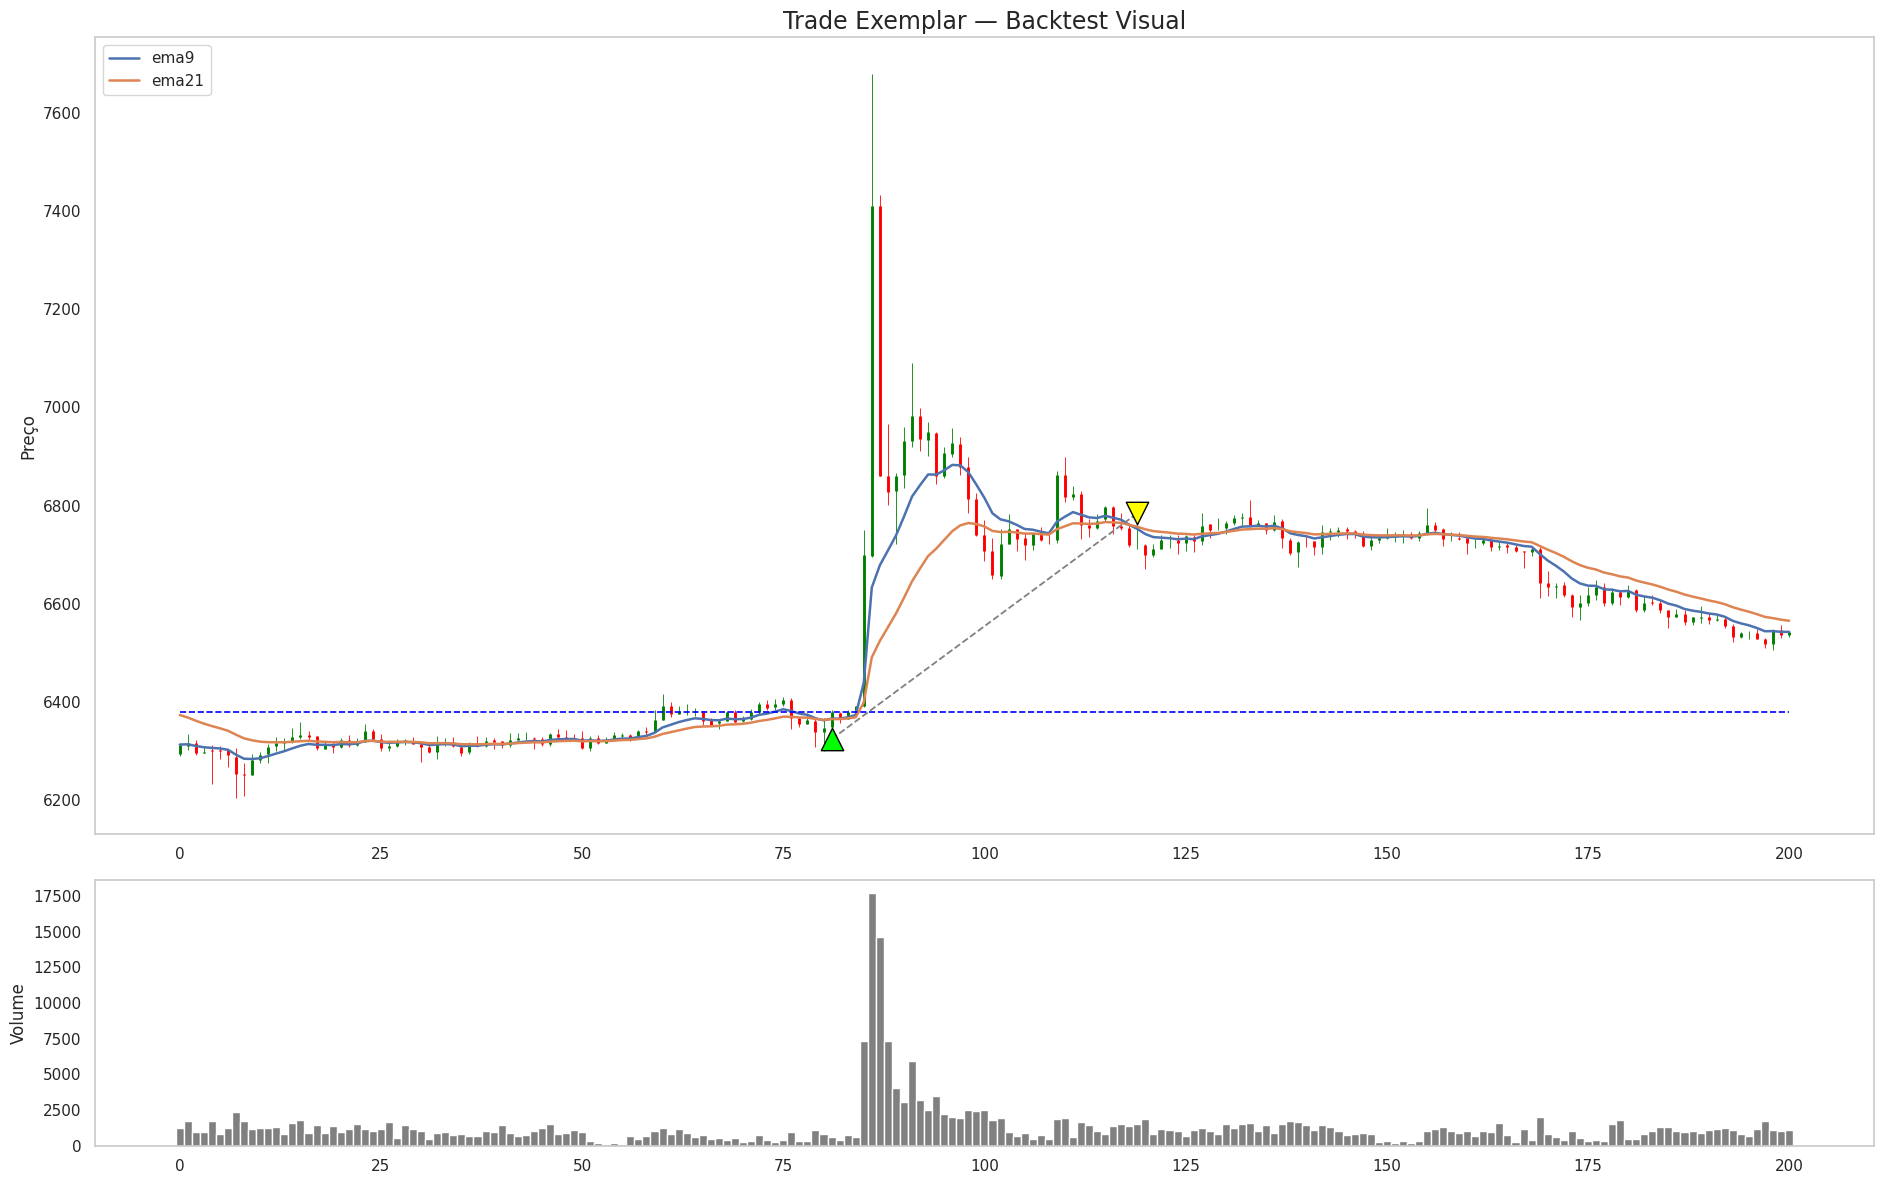

In [ ]:
# ============================================================
# TRADE EXEMPLAR — Versão 3.0 (Lindo, MT5-style)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

def plot_trade_exemplar(df, trades, indicadores_da_estrategia):
    if trades is None or trades.empty:
        print("⚠ Não há trades para mostrar.")
        return

    # ------ SORTEAR TRADE ------
    trade = trades.sample(1).iloc[0]
    entry_time = pd.to_datetime(trade['entry_time'])
    exit_time  = pd.to_datetime(trade['exit_time'])
    entry_px   = trade['entry_price']
    exit_px    = trade['exit_price']
    direction  = trade['direction']

    print("\n===== TRADE EXEMPLAR =====")
    print("Direção:", direction)
    print("Entrada:", entry_time, "@", entry_px)
    print("Saída:", exit_time, "@", exit_px)

    # ------ PREPARAR DF ------
    df2 = df.copy()
    df2["dt"] = pd.to_datetime(df2["datetime"])
    df2 = df2.set_index("dt")

    if entry_time not in df2.index or exit_time not in df2.index:
        print("⚠ Trade fora do histórico carregado.")
        return

    entry_i = df2.index.get_loc(entry_time)
    exit_i  = df2.index.get_loc(exit_time)

    # =========================================================
    # CENTRALIZAÇÃO DO TRADE NA JANELA
    # =========================================================

    # duração do trade em candles
    duracao = exit_i - entry_i

    # tamanho desejado da janela (você pode mudar)
    janela_total = 200

    # padding para deixar o trade centralizado
    padding = (janela_total - duracao) // 2
    padding = max(padding, 20)  # mínimo para não ficar muito apertado

    start_i = entry_i - padding
    end_i   = exit_i + padding

    # impedir que estoure o início/fim do df
    start_i = max(0, start_i)
    end_i   = min(len(df2) - 1, end_i)


    win = df2.iloc[start_i:end_i+1].reset_index(drop=True)

    opens  = win["open"].values
    highs  = win["high"].values
    lows   = win["low"].values
    closes = win["close"].values
    volume = win["volume"].values

    x = np.arange(len(win))
    up   = closes >= opens
    down = closes < opens

    # FIGURA
    fig = plt.figure(figsize=(19, 12))
    gs = fig.add_gridspec(2, 1, height_ratios=[3,1])
    ax = fig.add_subplot(gs[0])
    axv = fig.add_subplot(gs[1], sharex=ax)

    # ------ CANDLES ------
    ax.vlines(x[up],   lows[up], highs[up], color='green', linewidth=0.6)
    ax.vlines(x[down], lows[down], highs[down], color='red', linewidth=0.6)

    ax.vlines(x[up],   opens[up], closes[up], color='green', linewidth=2.1)
    ax.vlines(x[down], opens[down], closes[down], color='red', linewidth=2.1)

    # ------ INDICADORES ------
    for ind in indicadores_da_estrategia:
        if ind in win.columns:
            ax.plot(x, win[ind].values, linewidth=1.8, label=ind)

    if indicadores_da_estrategia:
        ax.legend(loc="upper left")

    # ------ POSIÇÕES DA SETA ------
    # Offset vertical automático
    px_min = win["low"].min()
    px_max = win["high"].max()
    offset = (px_max - px_min) * 0.015  # 1.5% da tela

    entry_local = entry_i - start_i
    exit_local  = exit_i - start_i

    if direction == "long":
        # entrada – seta verde abaixo
        entry_y = win["low"].iloc[entry_local] - offset
        ax.scatter(entry_local, entry_y, s=260, color="lime",
                   edgecolor="black", marker="^", zorder=5)

        # saída – seta amarela acima
        exit_y = win["high"].iloc[exit_local] + offset
        ax.scatter(exit_local, exit_y, s=260, color="yellow",
                   edgecolor="black", marker="v", zorder=5)

    else:
        # entrada – seta vermelha acima
        entry_y = win["high"].iloc[entry_local] + offset
        ax.scatter(entry_local, entry_y, s=260, color="red",
                   edgecolor="black", marker="v", zorder=5)

        # saída – seta roxa abaixo
        exit_y = win["low"].iloc[exit_local] - offset
        ax.scatter(exit_local, exit_y, s=260, color="purple",
                   edgecolor="black", marker="^", zorder=5)

    # ============================================================
    # DESENHAR LINHAS DE SL / TP (se existirem no trade)
    # ============================================================

    # Verifica se o trade contém SL/TP
    sl = trade.get("stop_price", None)
    tp = trade.get("take_price", None)

    # Linha da ENTRADA (sempre aparece)
    ax.hlines(entry_px, xmin=0, xmax=len(win)-1,
              colors="blue", linestyles="--", linewidth=1.2,
              label="Entrada")

    # Linha do STOP LOSS
    if sl is not None and not pd.isna(sl):
        ax.hlines(sl, xmin=0, xmax=len(win)-1,
                  colors="red", linestyles="--", linewidth=1.4,
                  label="Stop Loss")

    # Linha do TAKE PROFIT
    if tp is not None and not pd.isna(tp):
        ax.hlines(tp, xmin=0, xmax=len(win)-1,
                  colors="green", linestyles="--", linewidth=1.4,
                  label="Take Profit")

    # ------ LINHA CONECTANDO ENTRADA → SAÍDA ------
    ax.plot([entry_local, exit_local],
            [entry_y, exit_y],
            linestyle="--", linewidth=1.3, color="gray")

    # ------ LAYOUT ------
    ax.set_title("Trade Exemplar — Backtest Visual", fontsize=17)
    ax.set_ylabel("Preço")
    ax.grid(False)

    axv.bar(x, volume, color="gray", width=1)
    axv.set_ylabel("Volume")
    axv.grid(False)

    plt.tight_layout()
    plt.show()


plot_trade_exemplar(df, trades, indicadores_da_estrategia=indicadores_usados)




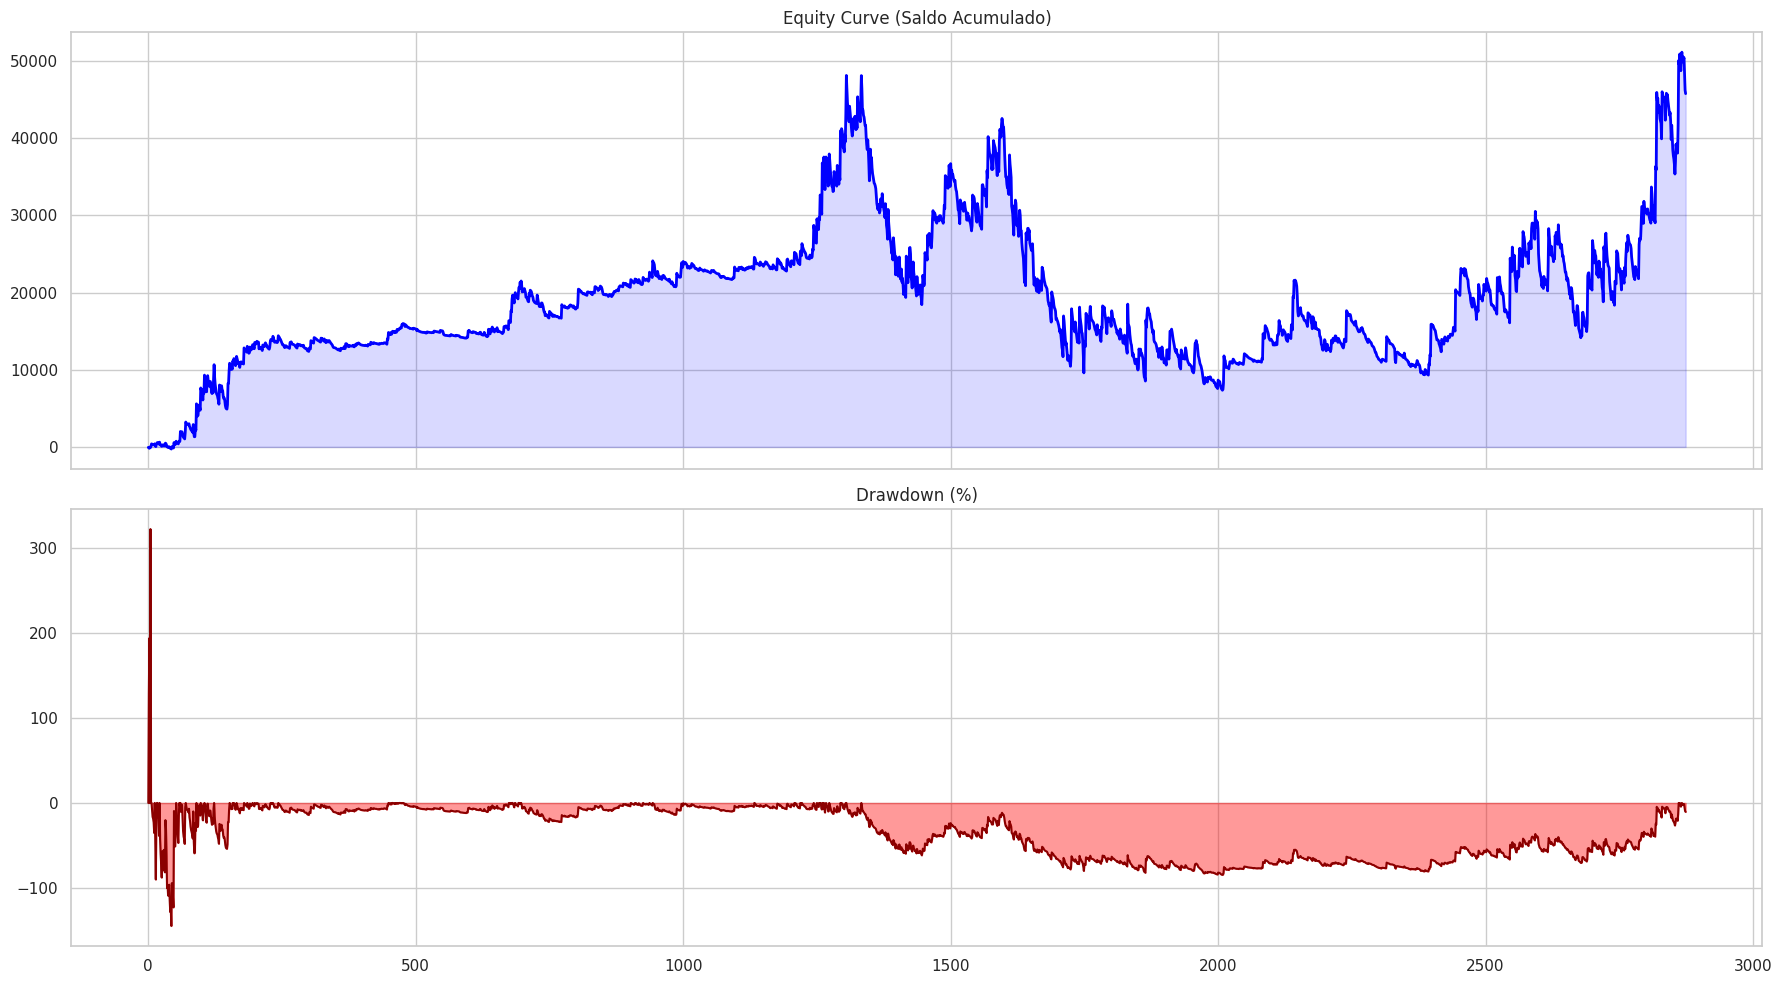

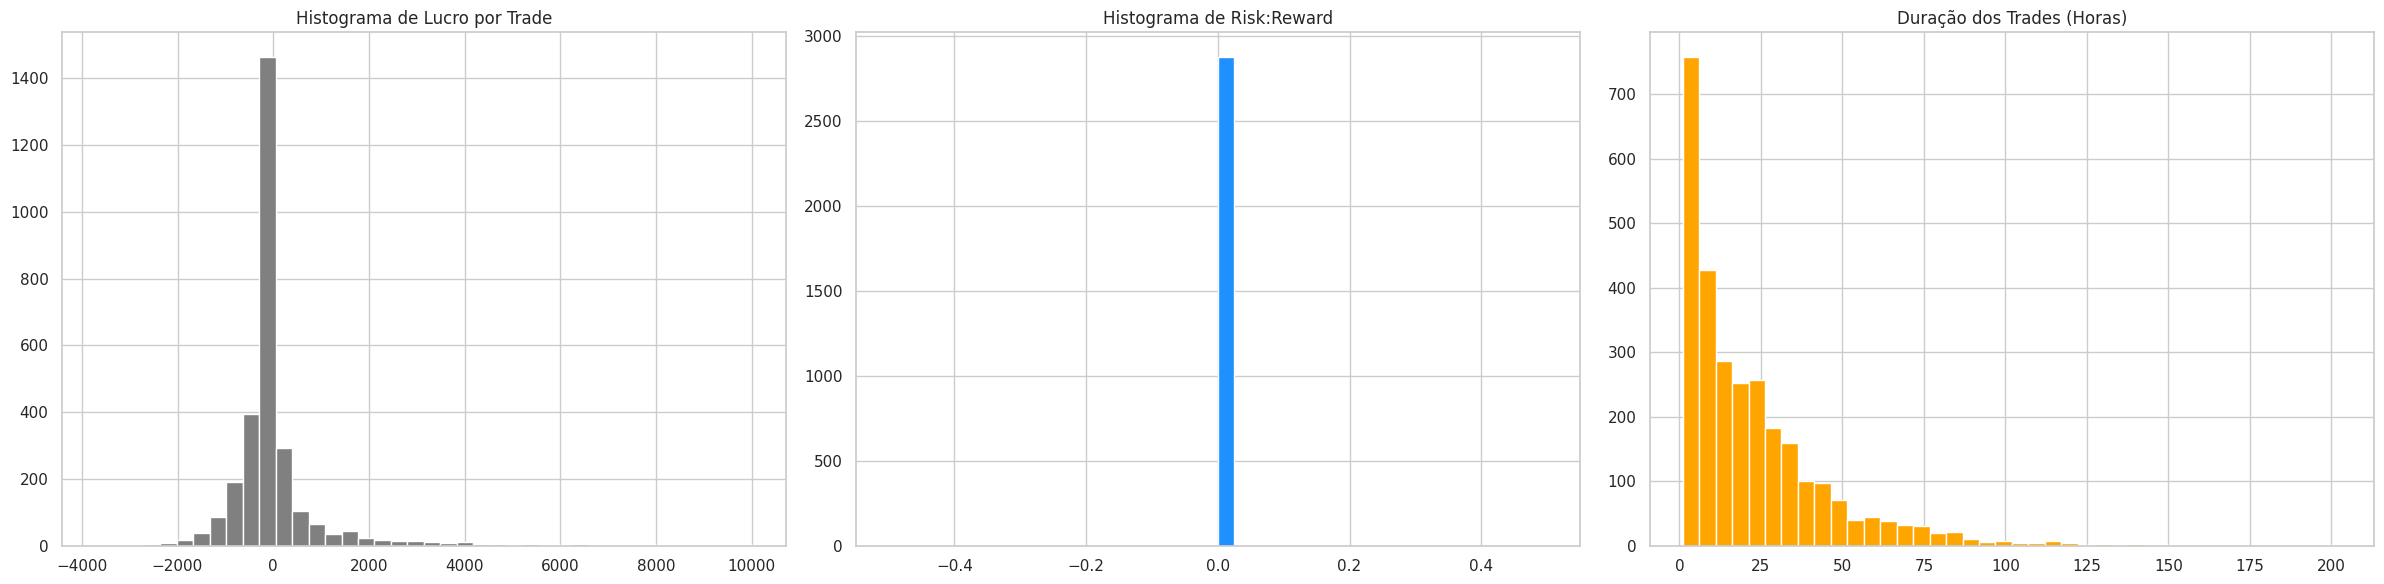

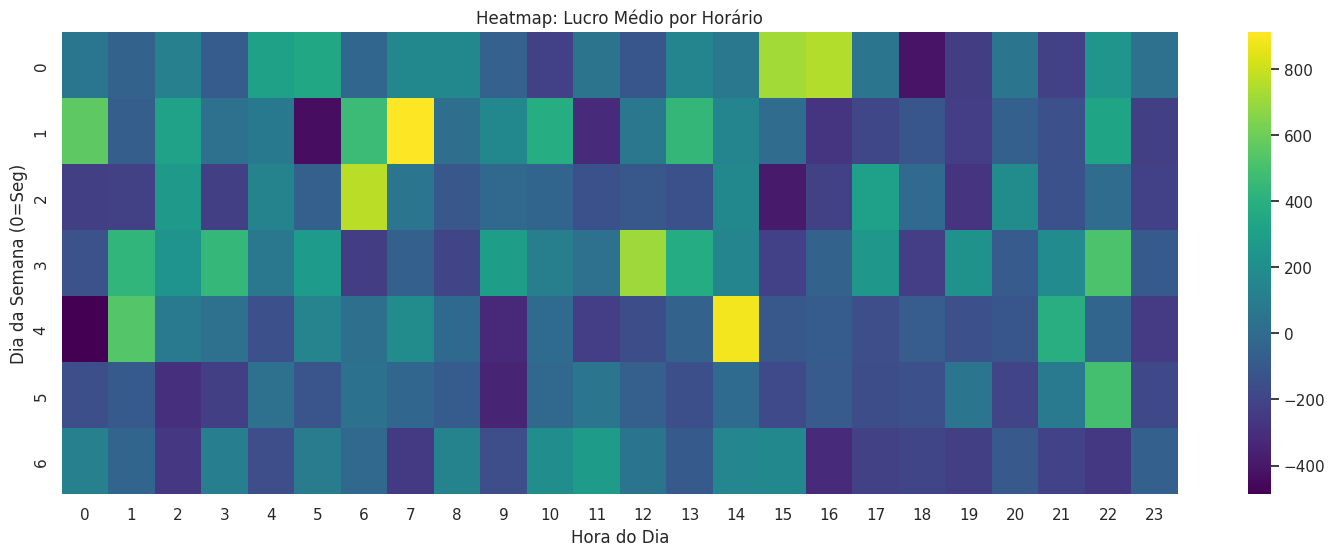

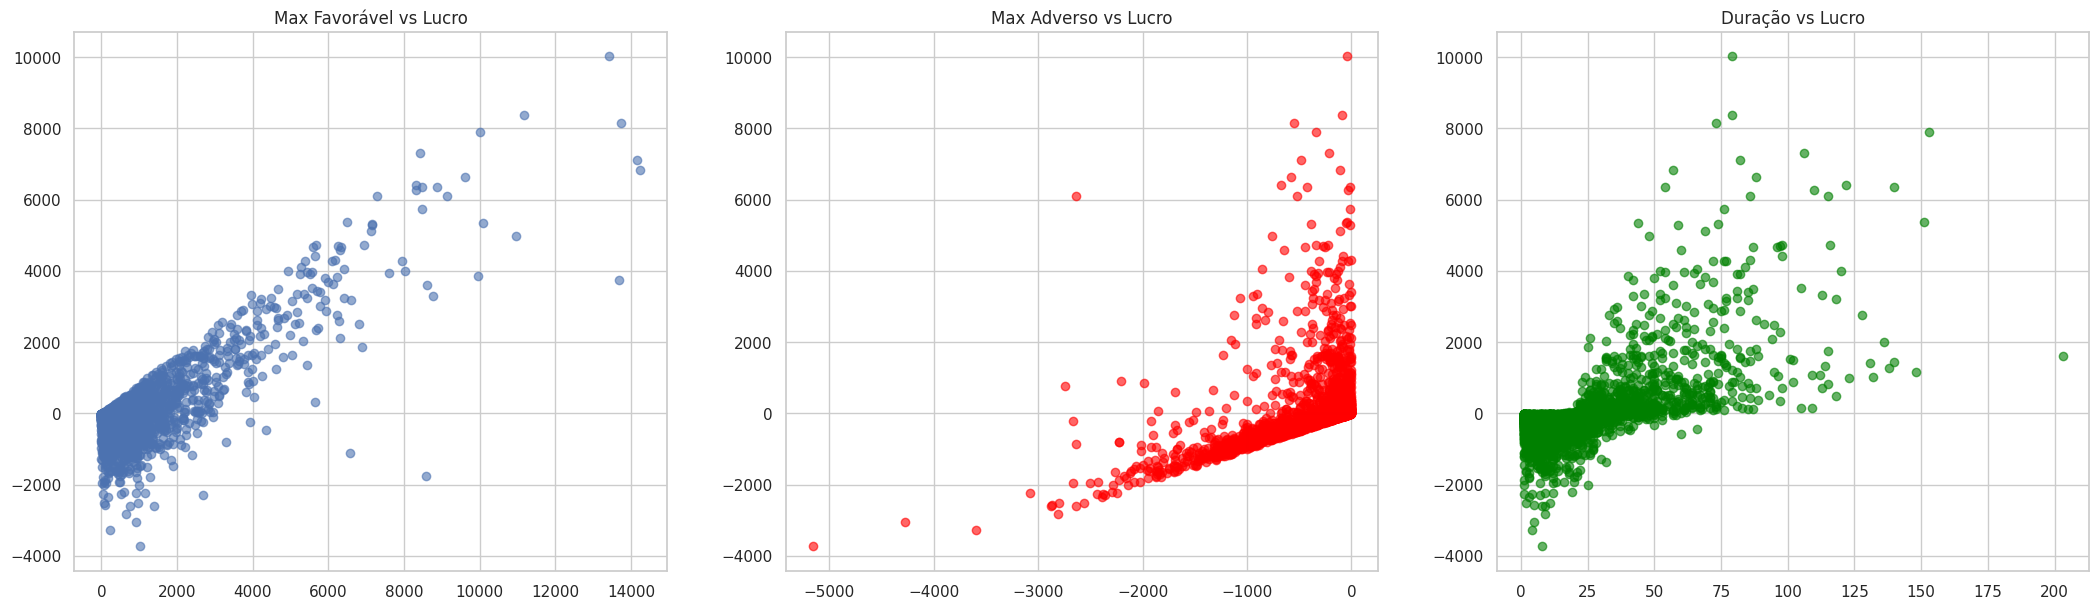

In [ ]:
# ============================================================
# FERRAMENTAS PARA GRÁFICOS AVANÇADOS (MT5 + StrategyQuant)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (16, 7)


def safe_float(x):
    try: return float(x)
    except: return np.nan

def plot_equity_and_dd(trades):
    if trades is None or trades.empty:
        print("⚠ Nenhum trade para plotar.")
        return

    # ---- EQUITY CURVE ----
    trades_sorted = trades.sort_values("exit_time")
    equity = trades_sorted["pnl"].cumsum()

    dd = equity - equity.cummax()
    dd_pct = dd / equity.cummax() * 100

    fig, ax = plt.subplots(2, 1, figsize=(18, 10), sharex=True)

    # Equity
    ax[0].plot(equity.values, color="blue", linewidth=2)
    ax[0].fill_between(np.arange(len(equity)), equity.values, color="blue", alpha=0.15)
    ax[0].set_title("Equity Curve (Saldo Acumulado)")
    ax[0].grid(True)

    # Drawdown
    ax[1].fill_between(np.arange(len(dd)), dd_pct.values, color="red", alpha=0.4)
    ax[1].plot(dd_pct.values, color="darkred", linewidth=1.5)
    ax[1].set_title("Drawdown (%)")
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()

def plot_histograms(trades):
    fig, ax = plt.subplots(1, 3, figsize=(24, 6))

    # PnL
    ax[0].hist(trades["pnl"], bins=40, color="gray")
    ax[0].set_title("Histograma de Lucro por Trade")

    # Risk:Reward
    if "risk" in trades.columns and trades["risk"].notna().any():
        rr = trades["pnl"] / trades["risk"].replace(0, np.nan)
    else:
        rr = np.zeros(len(trades))  # fallback seguro
    ax[1].hist(rr, bins=40, color="dodgerblue")
    ax[1].set_title("Histograma de Risk:Reward")

    # Duração
    # DURAÇÃO DO TRADE (fallback caso não exista)
    if "duration" in trades.columns and trades["duration"].notna().any():
        dur = trades["duration"].dt.total_seconds() / 3600
    else:
        dur = np.zeros(len(trades))

    ax[2].hist(dur, bins=40, color="orange")
    ax[2].set_title("Duração dos Trades (Horas)")

    plt.tight_layout()
    plt.show()


def plot_trade_time_heatmap(trades):
    trades["hour"] = trades["entry_time"].dt.hour
    trades["dow"] = trades["entry_time"].dt.dayofweek  # 0=Segunda

    pivot = trades.pivot_table(values="pnl", index="dow", columns="hour", aggfunc="mean")

    plt.figure(figsize=(18, 6))
    sns.heatmap(pivot, cmap="viridis", annot=False)
    plt.title("Heatmap: Lucro Médio por Horário")
    plt.ylabel("Dia da Semana (0=Seg)")
    plt.xlabel("Hora do Dia")
    plt.show()

def plot_trade_time_heatmap(trades):
    trades["hour"] = trades["entry_time"].dt.hour
    trades["dow"] = trades["entry_time"].dt.dayofweek  # 0=Segunda

    pivot = trades.pivot_table(values="pnl", index="dow", columns="hour", aggfunc="mean")

    plt.figure(figsize=(18, 6))
    sns.heatmap(pivot, cmap="viridis", annot=False)
    plt.title("Heatmap: Lucro Médio por Horário")
    plt.ylabel("Dia da Semana (0=Seg)")
    plt.xlabel("Hora do Dia")
    plt.show()

def plot_scatter_relations(trades):
    fig, ax = plt.subplots(1, 3, figsize=(26, 7))

    ax[0].scatter(trades["max_favor"], trades["pnl"], alpha=0.6)
    ax[0].set_title("Max Favorável vs Lucro")

    ax[1].scatter(trades["max_adverse"], trades["pnl"], alpha=0.6, color="red")
    ax[1].set_title("Max Adverso vs Lucro")

    dur = trades["duration"].dt.total_seconds()/3600
    ax[2].scatter(dur, trades["pnl"], alpha=0.6, color="green")
    ax[2].set_title("Duração vs Lucro")

    plt.show()

plot_equity_and_dd(trades)
plot_histograms(trades)
plot_trade_time_heatmap(trades)
plot_scatter_relations(trades)

===== 3D ATR/VOL/PnL =====
[INFO] Usando coluna ATR detectada: atr


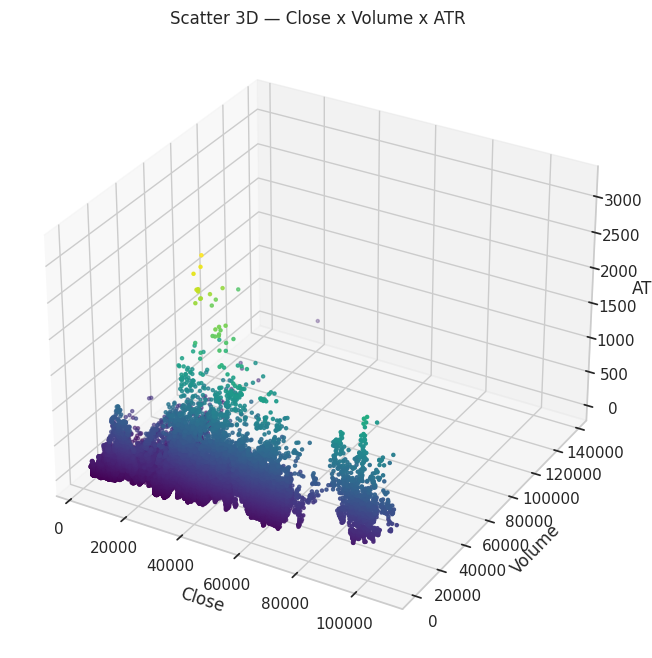

===== LUCRO POR MÊS =====


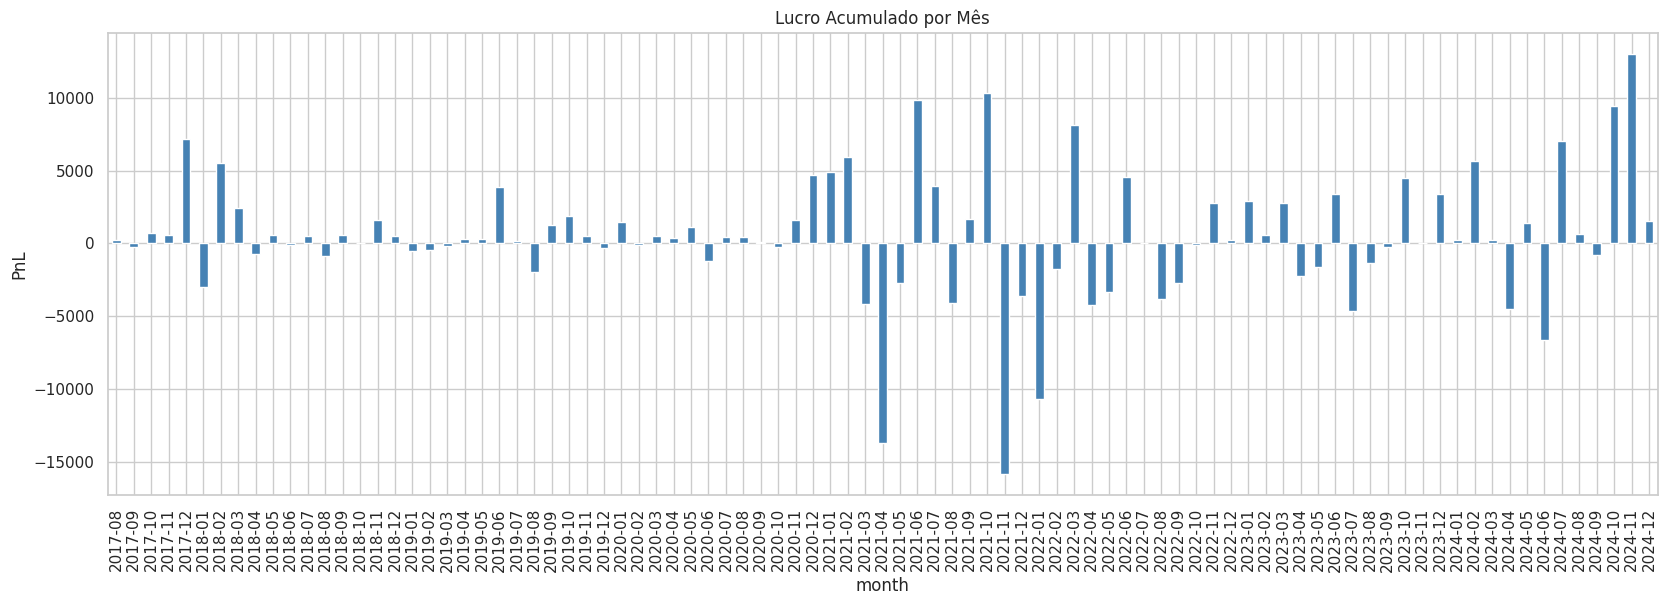

===== PROFIT FACTOR POR MÊS =====


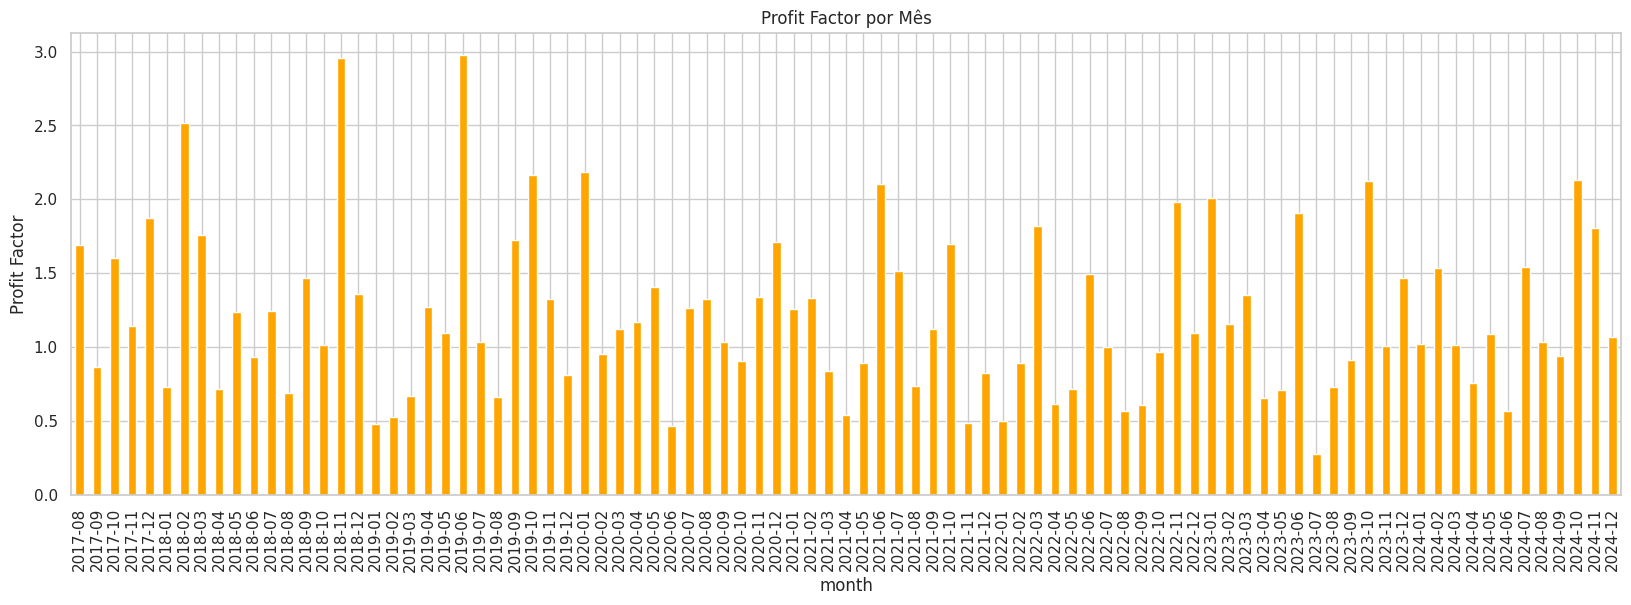

===== LUCRO POR ANO =====


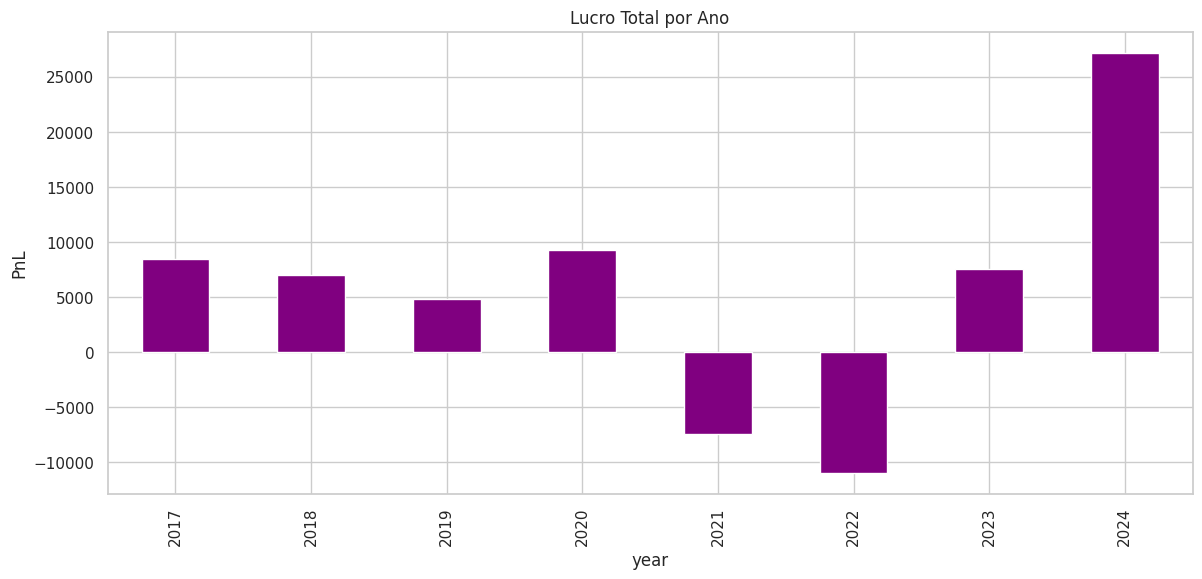

===== BEST & WORST =====


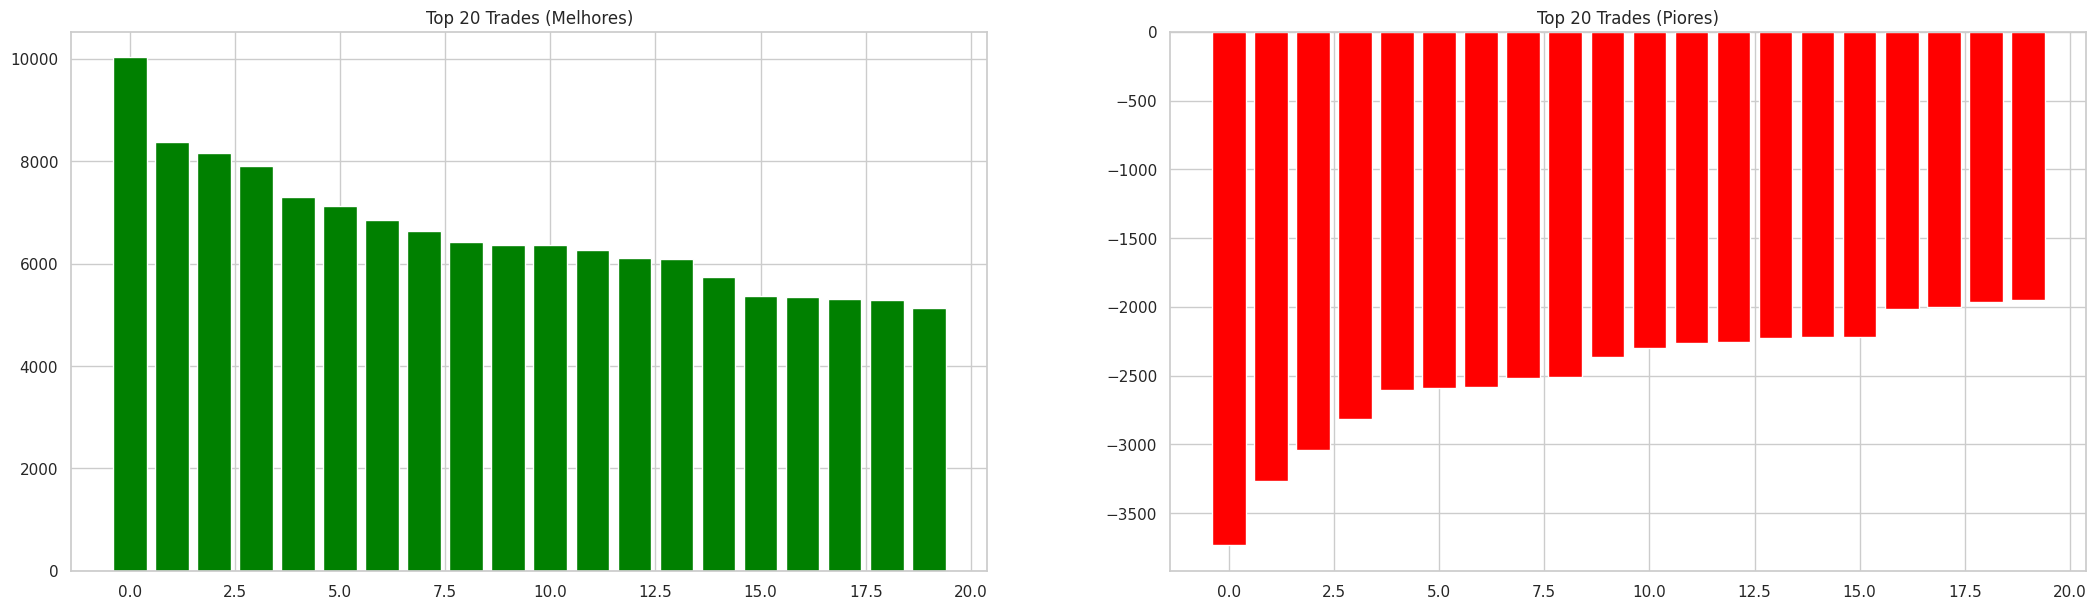

===== VOLATILIDADE × PNL =====


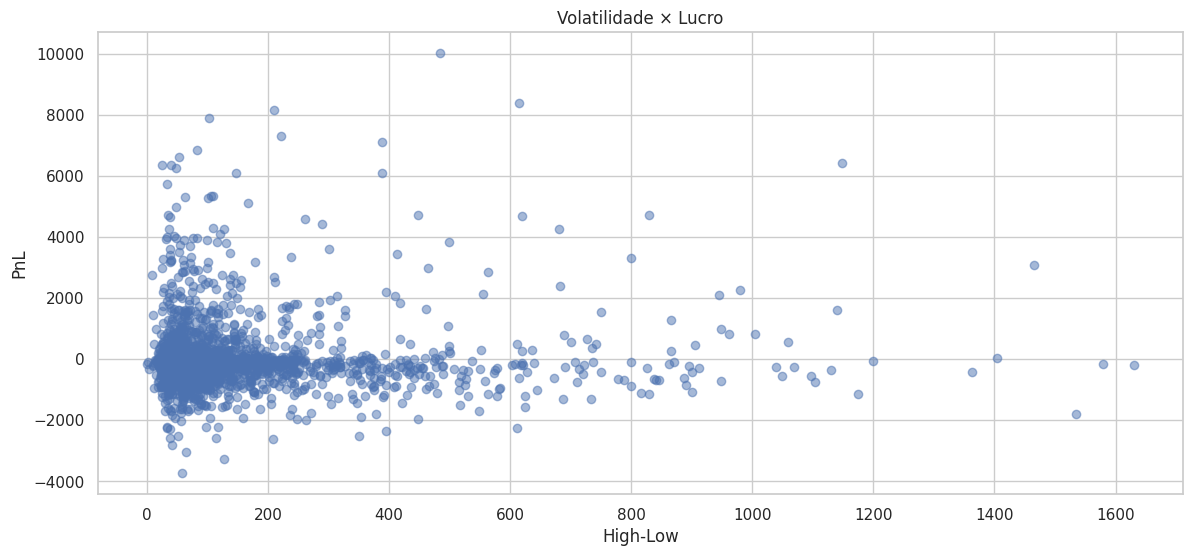

===== BOXPLOT SEMANAL =====


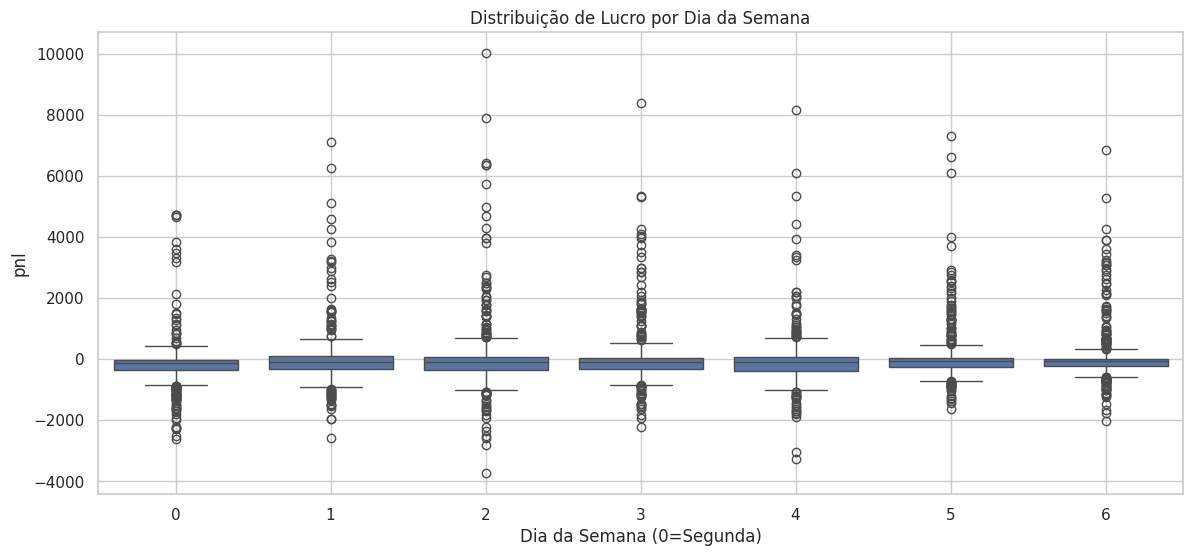

===== BOXPLOT HORÁRIO =====


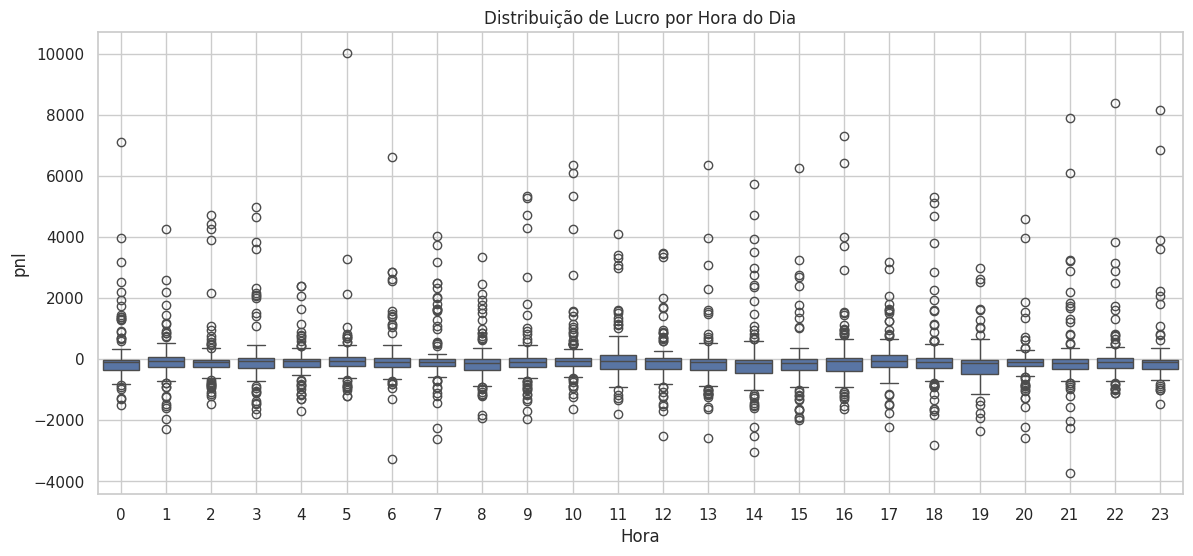

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# ============================================================
# PLOT 3D — agora detecta automaticamente o ATR existente
# ============================================================
def plot_3d_atr_volume_price(df):
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D  # obrigatório no Colab

    # Detectar automaticamente a coluna de ATR
    atr_col = next((c for c in df.columns if "atr" in c.lower()), None)

    if atr_col is None:
        raise ValueError(
            "Nenhuma coluna de ATR encontrada. "
            "Certifique-se que 'add_atr(df)' foi executado antes."
        )

    print(f"[INFO] Usando coluna ATR detectada: {atr_col}")

    # Criar figura
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection="3d")

    xs = df["close"].astype(float)
    ys = df["volume"].astype(float)
    zs = df[atr_col].astype(float)

    ax.scatter(xs, ys, zs, s=5, c=zs, cmap="viridis")

    ax.set_xlabel("Close")
    ax.set_ylabel("Volume")
    ax.set_zlabel(atr_col.upper())

    plt.title("Scatter 3D — Close x Volume x ATR")
    plt.show()


def plot_monthly_profit(trades):
    trades["month"] = trades["exit_time"].dt.to_period("M")
    month_pnl = trades.groupby("month")["pnl"].sum()

    plt.figure(figsize=(20,6))
    month_pnl.plot(kind="bar", color="steelblue")
    plt.title("Lucro Acumulado por Mês")
    plt.ylabel("PnL")
    plt.grid(True, axis="y")
    plt.show()

def plot_profit_factor_by_month(trades):
    trades["month"] = trades["exit_time"].dt.to_period("M")

    pf = trades.groupby("month").apply(
        lambda x: (x[x["pnl"]>0]["pnl"].sum() /
                   abs(x[x["pnl"]<0]["pnl"].sum()) )
                  if abs(x[x["pnl"]<0]["pnl"].sum()) > 0 else np.nan
    )

    plt.figure(figsize=(20,6))
    pf.plot(kind="bar", color="orange")
    plt.title("Profit Factor por Mês")
    plt.ylabel("Profit Factor")
    plt.grid(True, axis="y")
    plt.show()

def plot_yearly_profit(trades):
    trades["year"] = trades["exit_time"].dt.year
    pnl = trades.groupby("year")["pnl"].sum()

    plt.figure(figsize=(14,6))
    pnl.plot(kind="bar", color="purple")
    plt.title("Lucro Total por Ano")
    plt.ylabel("PnL")
    plt.grid(True, axis="y")
    plt.show()

def plot_best_and_worst_trades(trades, top=20):
    best = trades.nlargest(top, "pnl")
    worst = trades.nsmallest(top, "pnl")

    fig, ax = plt.subplots(1,2, figsize=(26,7))
    ax[0].bar(range(len(best)), best["pnl"], color="green")
    ax[0].set_title(f"Top {top} Trades (Melhores)")

    ax[1].bar(range(len(worst)), worst["pnl"], color="red")
    ax[1].set_title(f"Top {top} Trades (Piores)")

    plt.show()

def plot_volatility_vs_pnl(df, trades):
    vol = df["high"] - df["low"]
    n = min(len(vol), len(trades))
    vol = vol[:n]
    pnl = trades["pnl"][:n]

    plt.figure(figsize=(14,6))
    plt.scatter(vol, pnl, alpha=0.5)
    plt.title("Volatilidade × Lucro")
    plt.xlabel("High-Low")
    plt.ylabel("PnL")
    plt.grid(True)
    plt.show()

def plot_boxplot_weekday(trades):
    trades["weekday"] = trades["exit_time"].dt.dayofweek
    plt.figure(figsize=(14,6))
    sns.boxplot(data=trades, x="weekday", y="pnl")
    plt.title("Distribuição de Lucro por Dia da Semana")
    plt.xlabel("Dia da Semana (0=Segunda)")
    plt.grid(True)
    plt.show()

def plot_boxplot_hour(trades):
    trades["hour"] = trades["exit_time"].dt.hour
    plt.figure(figsize=(14,6))
    sns.boxplot(data=trades, x="hour", y="pnl")
    plt.title("Distribuição de Lucro por Hora do Dia")
    plt.xlabel("Hora")
    plt.grid(True)
    plt.show()

def full_dashboard(df, trades):

    print("===== 3D ATR/VOL/PnL =====")
    plot_3d_atr_volume_price(df_raw)

    print("===== LUCRO POR MÊS =====")
    plot_monthly_profit(trades)

    print("===== PROFIT FACTOR POR MÊS =====")
    plot_profit_factor_by_month(trades)

    print("===== LUCRO POR ANO =====")
    plot_yearly_profit(trades)

    print("===== BEST & WORST =====")
    plot_best_and_worst_trades(trades)

    print("===== VOLATILIDADE × PNL =====")
    plot_volatility_vs_pnl(df, trades)

    print("===== BOXPLOT SEMANAL =====")
    plot_boxplot_weekday(trades)

    print("===== BOXPLOT HORÁRIO =====")
    plot_boxplot_hour(trades)

full_dashboard(df, trades)



In [ ]:
# ============================================================
# ANALISE AVANÇADA PRO — MONTE CARLO, ROBUSTEZ, R-MULTIPLES
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")


# ============================================================
# 1) MONTE CARLO — ROLOU MESMO OU FOI SORTE?
# ============================================================

# ============================================================
# GERA SINAIS USANDO EMA FAST / SLOW (para robustez / heatmap)
# ============================================================
def generate_signals_ema_param(df, fast_period=9, slow_period=21):
    df = df.copy()

    df["ema_fast"] = df["close"].ewm(span=fast_period).mean()
    df["ema_slow"] = df["close"].ewm(span=slow_period).mean()

    df["signal"] = 0
    df.loc[df["ema_fast"] > df["ema_slow"], "signal"] = 1
    df.loc[df["ema_fast"] < df["ema_slow"], "signal"] = -1

    # DataFrame final: datetime + signal
    return df[["datetime", "signal"]]


def monte_carlo_equity(trades, initial_capital=1000.0, n_sims=200, mode="shuffle"):
    """
    Gera n_sims curvas de equity simuladas a partir da sequência de PnL.
    mode = 'shuffle'   -> embaralha ordem dos trades (permuta)
    mode = 'bootstrap' -> amostra com reposição (tamanho igual ao original)
    Retorna: np.ndarray (n_sims, n_trades)
    """
    pnl = trades["pnl"].values
    n = len(pnl)
    sims = []

    for i in range(n_sims):
        if mode == "bootstrap":
            sample = np.random.choice(pnl, size=n, replace=True)
        else:  # shuffle
            sample = np.random.permutation(pnl)

        eq = initial_capital + np.cumsum(sample)
        sims.append(eq)

    return np.array(sims)


def plot_monte_carlo(trades, initial_capital=1000.0, n_sims=200, mode="shuffle"):
    """
    Plota várias curvas de Monte Carlo + curva original.
    """
    if trades is None or trades.empty:
        print("⚠ Nenhum trade para Monte Carlo.")
        return

    sims = monte_carlo_equity(trades, initial_capital, n_sims, mode)
    pnl = trades.sort_values("exit_time")["pnl"].values
    eq_real = initial_capital + np.cumsum(pnl)

    plt.figure(figsize=(18, 8))
    for i in range(min(100, n_sims)):
        plt.plot(sims[i], color="gray", alpha=0.08)

    plt.plot(eq_real, color="cyan", linewidth=2, label="Equity Real")
    plt.title(f"Monte Carlo ({n_sims} simulações — modo {mode})")
    plt.xlabel("Trade")
    plt.ylabel("Equity")
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_monte_carlo_distribution(trades, initial_capital=1000.0, n_sims=1000, mode="bootstrap"):
    """
    Distribuição do saldo final e drawdown máximo nas simulações.
    """
    if trades is None or trades.empty:
        print("⚠ Nenhum trade para Monte Carlo.")
        return

    sims = monte_carlo_equity(trades, initial_capital, n_sims, mode)
    final_eq = sims[:, -1]

    # drawdown máximo em cada simulação
    max_dd_list = []
    for eq in sims:
        cummax = np.maximum.accumulate(eq)
        dd = eq - cummax
        max_dd_list.append(dd.min())
    max_dd = np.array(max_dd_list)

    fig, ax = plt.subplots(1, 2, figsize=(18, 6))

    ax[0].hist(final_eq, bins=40, color="steelblue", edgecolor="black")
    ax[0].set_title("Distribuição do Saldo Final (Monte Carlo)")
    ax[0].grid(True)

    ax[1].hist(max_dd, bins=40, color="red", edgecolor="black")
    ax[1].set_title("Distribuição do Max Drawdown (Monte Carlo)")
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()

    print(f"Saldo final (MC) — média: {final_eq.mean():.2f}, mediana: {np.median(final_eq):.2f}")
    print(f"Max DD (MC) — média: {max_dd.mean():.2f}, pior caso: {max_dd.min():.2f}")


def ema_grid_robustness(df, config, fast_range=range(5, 15), slow_range=range(15, 35)):
    """
    Roda um grid de EMAs (fast x slow) e mede lucro líquido.
    Retorna: matrix (len(fast_range) x len(slow_range)), listas fast_list, slow_list
    """
    fast_list = list(fast_range)
    slow_list = list(slow_range)

    results = np.full((len(fast_list), len(slow_list)), np.nan)

    for i, f in enumerate(fast_list):
        for j, s in enumerate(slow_list):
            if f >= s:  # filtro para não usar EMA rápida >= lenta
                continue
            signals = generate_signals_ema_param(df, fast_period=f, slow_period=s)
            bt = Backtester(df, config)
            tr = bt.run(signals)
            if tr is None or tr.empty:
                metric = np.nan
            else:
                metric = tr["pnl"].sum()  # lucro líquido total
            results[i, j] = metric

    return results, fast_list, slow_list


def plot_ema_robustness_heatmap(df, config,
                                fast_range=range(5, 15),
                                slow_range=range(15, 35)):
    """
    Plota heatmap de robustez de parâmetros (lucro líquido).
    """
    res, fast_list, slow_list = ema_grid_robustness(df, config, fast_range, slow_range)

    plt.figure(figsize=(10, 8))
    sns.heatmap(res, xticklabels=slow_list, yticklabels=fast_list, cmap="RdYlGn", center=0)
    plt.xlabel("EMA Lenta")
    plt.ylabel("EMA Rápida")
    plt.title("Mapa de Robustez — Lucro por (EMA Rápida x Lenta)")
    plt.show()


# ============================================================
# 3) R-MULTIPLES & KELLY
# ============================================================

def compute_r_multiples(trades):
    """
    Calcula R-Multiples usando max_adverse como proxy de risco.
    (Ideia: quanto o trade andou CONTRA você = risco exposto)
    """
    tr = trades.copy()

    # max_adverse é negativo (pior excursão). Usamos o módulo.
    base_risk = tr["max_adverse"].abs()
    base_risk = base_risk.replace(0, np.nan)

    tr["R"] = tr["pnl"] / base_risk
    return tr


def summarize_r_and_kelly(trades):
    """
    Imprime estatísticas de R-Multiples e Kelly Fraction.
    """
    tr = compute_r_multiples(trades)
    r = tr["R"].replace([np.inf, -np.inf], np.nan).dropna()

    if r.empty:
        print("⚠ Não foi possível calcular R-Multiples (risco zero ou dados insuficientes).")
        return

    wins  = tr[tr["pnl"] > 0]
    losses = tr[tr["pnl"] < 0]

    win_rate = len(wins) / len(tr) if len(tr) > 0 else 0
    avg_win  = wins["pnl"].mean() if not wins.empty else 0
    avg_loss = losses["pnl"].mean() if not losses.empty else 0  # negativo

    if avg_loss >= 0:
        R_avg = np.nan
    else:
        R_avg = avg_win / abs(avg_loss)

    expectancy = r.mean()

    # Fórmula Kelly clássica: f* = p - q/R
    if R_avg is not np.nan and R_avg is not None and R_avg > 0:
        kelly = win_rate - (1 - win_rate) / R_avg
    else:
        kelly = np.nan

    print("===== R-MULTIPLES & KELLY =====")
    print(f"N trades considerados: {len(tr)}")
    print(f"Média de R: {expectancy:.3f}")
    print(f"Win rate: {win_rate*100:.2f}%")
    print(f"Avg Win: {avg_win:.2f}")
    print(f"Avg Loss: {avg_loss:.2f}")
    print(f"R médio (AvgWin/|AvgLoss|): {R_avg:.3f}" if not np.isnan(R_avg) else "R médio: N/A")
    print(f"Kelly Fraction (teórico): {kelly:.3f}" if not np.isnan(kelly) else "Kelly: N/A")

    # Histograma de R
    plt.figure(figsize=(10, 4))
    plt.hist(r, bins=50, color="gray", edgecolor="black")
    plt.title("Histograma de R-Multiples")
    plt.xlabel("R")
    plt.ylabel("Frequência")
    plt.grid(True)
    plt.show()


# ============================================================
# 4) FUNÇÃO RESUMO — RODAR TUDO DE UMA VEZ
# ============================================================

def advanced_analysis_dashboard(df, trades, config, initial_capital=1000.0):
    """
    Roda tudo: Monte Carlo, Robustez EMA, R-Multiples & Kelly.
    """
    if trades is None or trades.empty:
        print("⚠ Nenhum trade disponível para análise avançada.")
        return

    print("\n===== MONTE CARLO (Equity) =====")
    plot_monte_carlo(trades, initial_capital=initial_capital, n_sims=10000, mode="shuffle")

    print("\n===== MONTE CARLO (Distribuição) =====")
    plot_monte_carlo_distribution(trades, initial_capital=initial_capital, n_sims=500, mode="bootstrap")

    print("\n===== ROBUSTEZ EMA (Heatmap) =====")
    # Pode ajustar os ranges se quiser mais/menos granular
    plot_ema_robustness_heatmap(df, config,
                                fast_range=range(5, 15),
                                slow_range=range(15, 35))

    print("\n===== R-MULTIPLES & KELLY =====")
    summarize_r_and_kelly(trades)

    print("\n===== FIM DA ANÁLISE AVANÇADA =====")


===== MONTE CARLO (Equity) =====


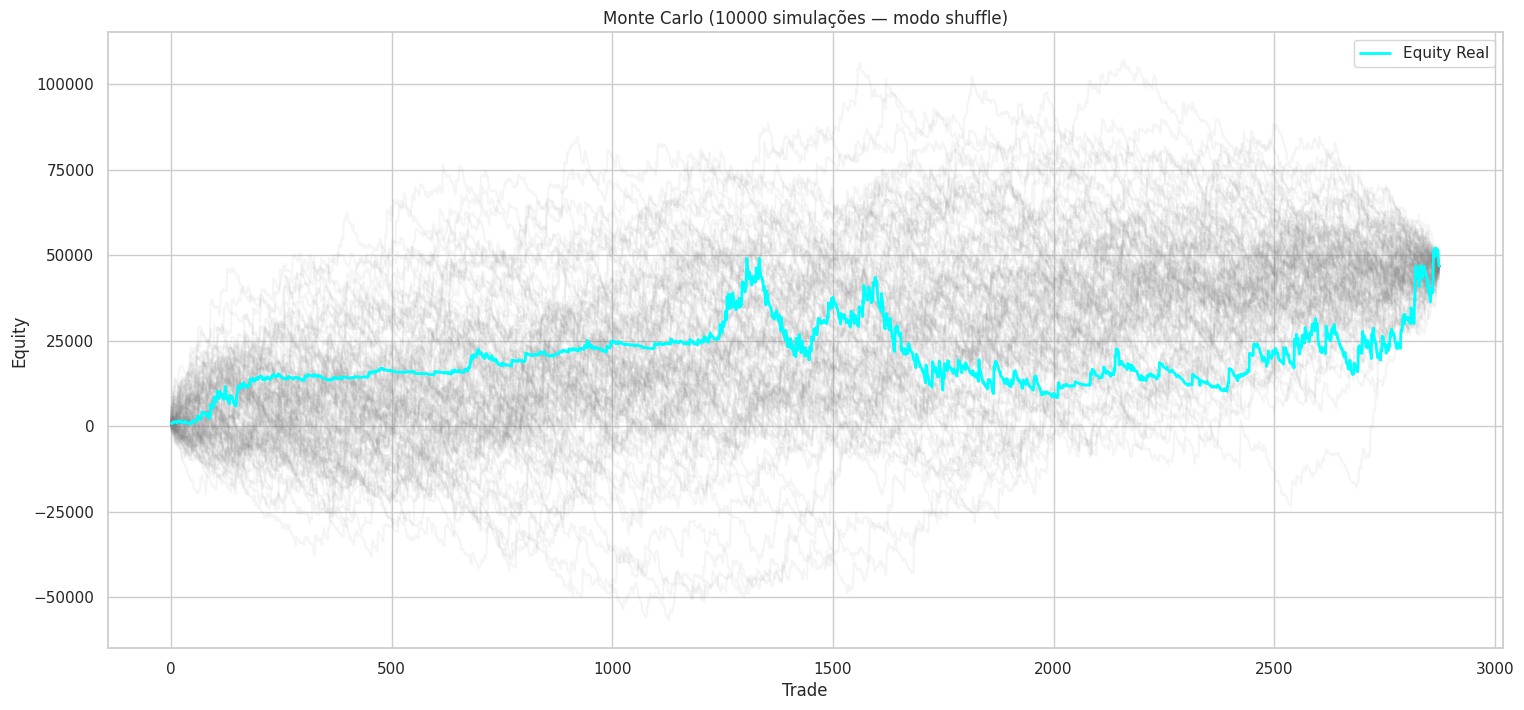


===== MONTE CARLO (Distribuição) =====


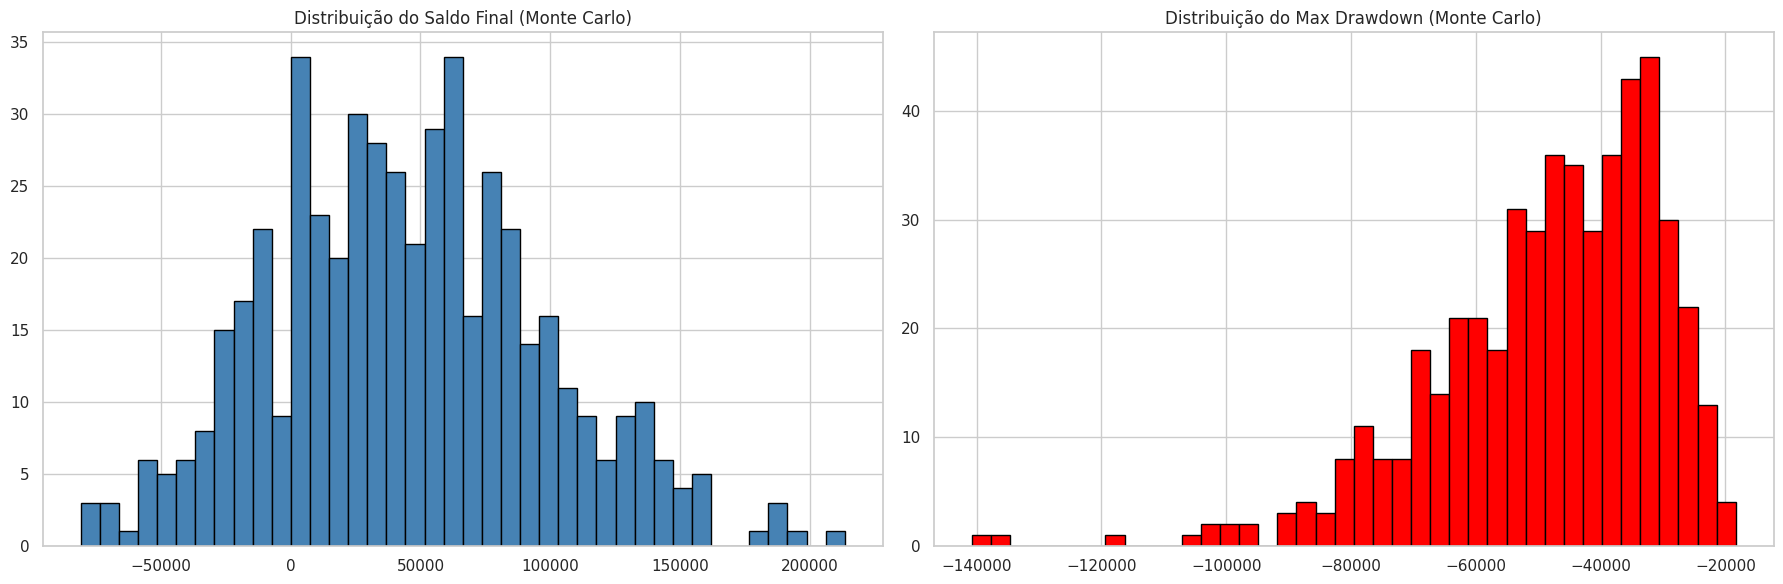

Saldo final (MC) — média: 44875.05, mediana: 42983.51
Max DD (MC) — média: -48321.58, pior caso: -140782.71

===== ROBUSTEZ EMA (Heatmap) =====


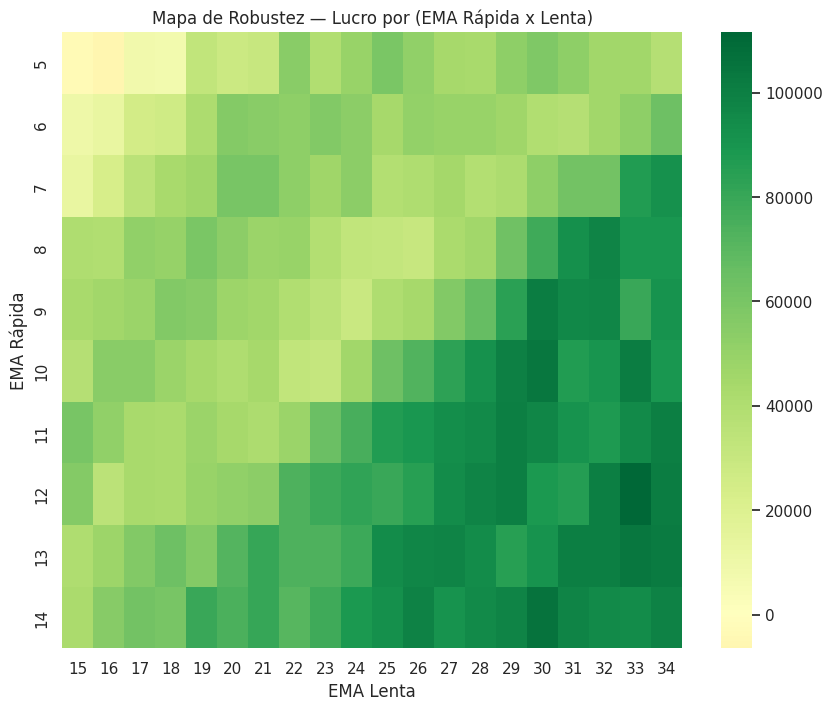


===== R-MULTIPLES & KELLY =====
===== R-MULTIPLES & KELLY =====
N trades considerados: 2875
Média de R: 106.027
Win rate: 27.27%
Avg Win: 942.40
Avg Loss: -331.60
R médio (AvgWin/|AvgLoss|): 2.842
Kelly Fraction (teórico): 0.017


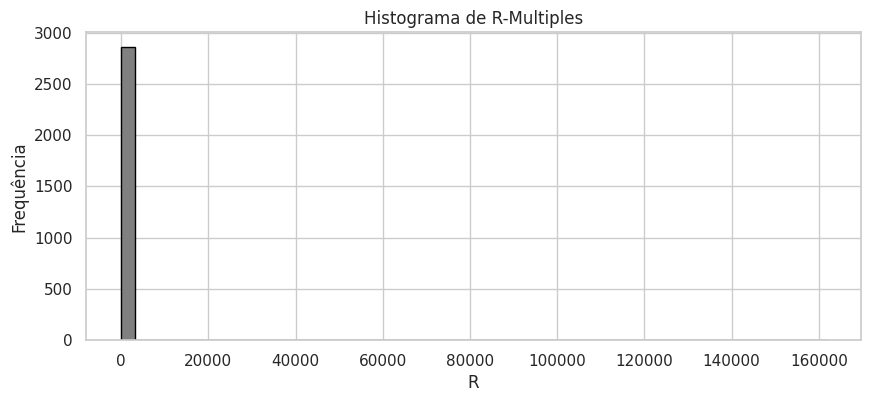


===== FIM DA ANÁLISE AVANÇADA =====


In [ ]:
advanced_analysis_dashboard(
    df,
    trades,
    CONFIG,
    initial_capital=CONFIG.get("initial_capital", 1000.0)
)


In [ ]:
# ============================================================
# RELATÓRIO HTML PRO — BASE64 + EXPLICAÇÕES DE CADA GRÁFICO
# ============================================================

import base64, io, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")


# ------------------------------------------------------------
# Helpers
# ------------------------------------------------------------
def fig_to_base64(fig):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=120, bbox_inches="tight")
    buf.seek(0)
    b64 = base64.b64encode(buf.read()).decode("utf-8")
    buf.close()
    plt.close(fig)
    return f"data:image/png;base64,{b64}"


# ============================================================
# MÉTRICAS
# ============================================================
def compute_metrics_html(trades, initial_capital=1000.0):
    tr = trades.sort_values("exit_time")
    equity = initial_capital + tr["pnl"].cumsum()

    final_balance = equity.iloc[-1]
    net_profit    = final_balance - initial_capital
    total         = len(tr)
    wins          = (tr["pnl"] > 0).sum()
    losses        = (tr["pnl"] < 0).sum()
    win_rate      = (wins / total * 100) if total > 0 else 0.0
    gross_profit  = tr[tr["pnl"] > 0]["pnl"].sum()
    gross_loss    = tr[tr["pnl"] < 0]["pnl"].sum()
    profit_factor = gross_profit / abs(gross_loss) if gross_loss < 0 else np.nan

    dd        = equity - equity.cummax()
    max_dd    = dd.min()
    max_dd_pct = (max_dd / equity.cummax().max()) * 100

    expectancy = net_profit / total if total > 0 else 0.0
    sharpe     = tr["pnl"].mean() / (tr["pnl"].std() + 1e-9)

    dfm = pd.DataFrame([
        ("Capital Inicial", initial_capital),
        ("Saldo Final", float(final_balance)),
        ("Resultado Líquido", float(net_profit)),
        ("Total de Trades", int(total)),
        ("Vitórias", int(wins)),
        ("Derrotas", int(losses)),
        ("Taxa de Acerto (%)", float(win_rate)),
        ("Lucro Bruto", float(gross_profit)),
        ("Prejuízo Bruto", float(gross_loss)),
        ("Profit Factor", float(profit_factor)),
        ("Max Drawdown (valor)", float(max_dd)),
        ("Max Drawdown (%)", float(max_dd_pct)),
        ("Expectativa por Trade", float(expectancy)),
        ("Sharpe Ratio", float(sharpe)),
    ], columns=["Métrica", "Valor"])

    return dfm.to_html(index=False, classes="metrics-table")


# ============================================================
# GRÁFICOS BÁSICOS (os que você já tinha)
# ============================================================
def chart_equity_dd(trades, initial_capital=1000.0):
    tr = trades.sort_values("exit_time")
    equity = initial_capital + tr["pnl"].cumsum()
    dd = equity - equity.cummax()
    dd_pct = dd / equity.cummax().replace(0, np.nan) * 100

    fig, ax = plt.subplots(2, 1, figsize=(18, 10), sharex=True)
    ax[0].plot(equity.values, color="cyan", linewidth=2)
    ax[0].set_title("Equity Curve")
    ax[0].grid(True)

    ax[1].fill_between(range(len(dd_pct)), dd_pct, color="red", alpha=0.4)
    ax[1].set_title("Drawdown (%)")
    ax[1].grid(True)

    return fig_to_base64(fig)


def chart_histogram_pnl(trades):
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.hist(trades["pnl"], bins=40, color="gray", edgecolor="white")
    ax.set_title("Histograma de Lucro por Trade")
    ax.grid(True)
    return fig_to_base64(fig)


def chart_heatmap(trades):
    tr = trades.copy()
    tr["hour"] = tr["entry_time"].dt.hour
    tr["dow"]  = tr["entry_time"].dt.dayofweek
    pivot = tr.pivot_table(values="pnl", index="dow", columns="hour", aggfunc="mean")

    fig, ax = plt.subplots(figsize=(14, 4))
    sns.heatmap(pivot, cmap="viridis", ax=ax)
    ax.set_title("Heatmap — Lucro Médio por Hora/Dia")
    return fig_to_base64(fig)


def chart_monthly_pnl(trades):
    t = trades.copy()
    t["month"] = t["exit_time"].dt.to_period("M")
    m = t.groupby("month")["pnl"].sum()

    fig, ax = plt.subplots(figsize=(14, 4))
    m.plot(kind="bar", ax=ax, color="dodgerblue")
    ax.set_title("Lucro por Mês")
    ax.set_xlabel("month")
    ax.grid(True, axis="y")
    return fig_to_base64(fig)


def chart_yearly_pnl(trades):
    t = trades.copy()
    t["year"] = t["exit_time"].dt.year
    y = t.groupby("year")["pnl"].sum()

    fig, ax = plt.subplots(figsize=(10, 4))
    y.plot(kind="bar", ax=ax, color="purple")
    ax.set_title("Lucro por Ano")
    ax.set_xlabel("year")
    ax.grid(True, axis="y")
    return fig_to_base64(fig)


def chart_best_worst(trades):
    best = trades.nlargest(20, "pnl")
    worst = trades.nsmallest(20, "pnl")

    fig, ax = plt.subplots(1, 2, figsize=(18, 5))
    ax[0].bar(range(len(best)), best["pnl"], color="green")
    ax[0].set_title("Top 20 Trades (Melhores)")
    ax[1].bar(range(len(worst)), worst["pnl"], color="red")
    ax[1].set_title("Top 20 Trades (Piores)")
    return fig_to_base64(fig)


# ============================================================
# GRÁFICOS AVANÇADOS — MONTE CARLO, ROBUSTEZ, R-MULTIPLES
# ============================================================

def chart_monte_carlo_equity(trades, initial_capital=1000.0, n_sims=200):
    pnl = trades.sort_values("exit_time")["pnl"].values
    n   = len(pnl)
    sims = []
    for _ in range(n_sims):
        sample = np.random.permutation(pnl)
        eq = initial_capital + np.cumsum(sample)
        sims.append(eq)
    sims = np.array(sims)
    eq_real = initial_capital + np.cumsum(pnl)

    fig, ax = plt.subplots(figsize=(18, 8))
    for i in range(min(80, n_sims)):
        ax.plot(sims[i], color="gray", alpha=0.08)
    ax.plot(eq_real, color="cyan", linewidth=2, label="Equity Real")
    ax.set_title(f"Monte Carlo — Equity (shuffle, {n_sims} simulações)")
    ax.set_xlabel("Trade")
    ax.set_ylabel("Equity")
    ax.grid(True)
    ax.legend()
    return fig_to_base64(fig)


def chart_monte_carlo_distribution(trades, initial_capital=1000.0, n_sims=500):
    pnl = trades.sort_values("exit_time")["pnl"].values
    n   = len(pnl)
    finals = []
    max_dds = []

    for _ in range(n_sims):
        sample = np.random.choice(pnl, size=n, replace=True)
        eq = initial_capital + np.cumsum(sample)
        finals.append(eq[-1])
        cummax = np.maximum.accumulate(eq)
        dd = eq - cummax
        max_dds.append(dd.min())

    finals = np.array(finals)
    max_dds = np.array(max_dds)

    fig, ax = plt.subplots(1, 2, figsize=(18, 6))
    ax[0].hist(finals, bins=40, color="steelblue", edgecolor="black")
    ax[0].set_title("Monte Carlo — Distribuição do Saldo Final")
    ax[0].grid(True)

    ax[1].hist(max_dds, bins=40, color="red", edgecolor="black")
    ax[1].set_title("Monte Carlo — Distribuição do Max Drawdown")
    ax[1].grid(True)

    return fig_to_base64(fig)


def generate_signals_ema_param(df, fast_period=9, slow_period=21):
    data = df.copy()
    data["datetime"] = pd.to_datetime(data["datetime"])
    fast = data["close"].ewm(span=fast_period, adjust=False).mean()
    slow = data["close"].ewm(span=slow_period, adjust=False).mean()
    prev_fast = fast.shift(1)
    prev_slow = slow.shift(1)
    buy  = (prev_fast <= prev_slow) & (fast > slow)
    sell = (prev_fast >= prev_slow) & (fast < slow)
    sig = pd.DataFrame({"datetime": data["datetime"], "signal": 0})
    sig.loc[buy,  "signal"] = 1
    sig.loc[sell, "signal"] = -1
    return sig


def chart_ema_robustness(df, config,
                         fast_range=range(5, 15),
                         slow_range=range(15, 35)):
    fast_list = list(fast_range)
    slow_list = list(slow_range)
    res = np.full((len(fast_list), len(slow_list)), np.nan)

    for i, f in enumerate(fast_list):
        for j, s in enumerate(slow_list):
            if f >= s:
                continue
            sig = generate_signals_ema_param(df, fast_period=f, slow_period=s)
            bt = Backtester(df, config)
            tr = bt.run(sig)
            metric = tr["pnl"].sum() if tr is not None and not tr.empty else np.nan
            res[i, j] = metric

    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(res, xticklabels=slow_list, yticklabels=fast_list,
                cmap="RdYlGn", center=0, ax=ax)
    ax.set_title("Mapa de Robustez — Lucro por EMA Rápida x Lenta")
    ax.set_xlabel("EMA Lenta")
    ax.set_ylabel("EMA Rápida")
    return fig_to_base64(fig)


def chart_r_multiples(trades):
    tr = trades.copy()
    if "max_adverse" in tr.columns:
        risk = tr["max_adverse"].abs().replace(0, np.nan)
        tr["R"] = tr["pnl"] / risk
        r = tr["R"].replace([np.inf, -np.inf], np.nan).dropna()
    else:
        r = pd.Series([], dtype=float)

    fig, ax = plt.subplots(figsize=(10, 4))
    if not r.empty:
        ax.hist(r, bins=40, color="gray", edgecolor="black")
    ax.set_title("Histograma de R-Multiples (PnL / risco do trade)")
    ax.grid(True)
    return fig_to_base64(fig)


# ============================================================
# GERADOR HTML FINAL
# ============================================================

def generate_html_report_base64(df, trades, config,
                                initial_capital=1000.0,
                                output_path="/content/backtest_report.html"):
    if trades is None or trades.empty:
        print("⚠ Sem trades, nenhum relatório será gerado.")
        return

    metrics_html  = compute_metrics_html(trades, initial_capital)
    img_equity_dd = chart_equity_dd(trades, initial_capital)
    img_hist_pnl  = chart_histogram_pnl(trades)
    img_heatmap   = chart_heatmap(trades)
    img_monthly   = chart_monthly_pnl(trades)
    img_yearly    = chart_yearly_pnl(trades)
    img_bw        = chart_best_worst(trades)

    img_mc_eq   = chart_monte_carlo_equity(trades, initial_capital)
    img_mc_dist = chart_monte_carlo_distribution(trades, initial_capital)
    img_robust  = chart_ema_robustness(df, config)
    img_rmult   = chart_r_multiples(trades)

    trades_html = trades.to_html(index=False, classes="trades-table")

    html = f"""
<!DOCTYPE html>
<html lang="pt-br">
<head>
<meta charset="utf-8">
<title>Relatório de Backtest — BTC Framework</title>
<style>
body {{
    font-family: Arial, sans-serif;
    background-color: #0f172a;
    color: #e2e8f0;
    margin: 0;
}}
h1, h2, h3 {{
    color: #fbbf24;
}}
.container {{ width: 95%; margin: 0 auto 40px auto; }}
.card {{
    background-color: #1e293b;
    margin-top: 20px;
    padding: 20px;
    border-radius: 10px;
    box-shadow: 0 0 12px rgba(0,0,0,0.5);
}}
img {{
    max-width: 100%;
    border-radius: 8px;
    border: 1px solid #334155;
}}
.metrics-table, .trades-table {{
    width: 100%;
    border-collapse: collapse;
    font-size: 14px;
}}
.metrics-table th, .metrics-table td,
.trades-table th, .trades-table td {{
    border: 1px solid #334155;
    padding: 6px 8px;
}}
.trades-wrapper {{
    max-height: 400px;
    overflow-y: auto;
    border-radius: 6px;
    border: 1px solid #334155;
}}
details {{
    margin-top: 8px;
    background-color: #020617;
    border-radius: 6px;
    padding: 6px 10px;
    border: 1px solid #1f2937;
}}
details summary {{
    cursor: pointer;
    font-weight: bold;
    color: #facc15;
}}
</style>
</head>
<body>
<div class="container">

  <div class="card">
    <h1>Relatório de Backtest — BTC Framework</h1>
    <p>Gerado automaticamente com Python + CCXT + Backtester PRO.</p>
  </div>

  <div class="card">
    <h2>Métricas Gerais</h2>
    {metrics_html}
  </div>

  <div class="card">
    <h2>Equity & Drawdown</h2>
    <img src="{img_equity_dd}">
    <details><summary>Como interpretar</summary>
      <p>Equity mostra a evolução acumulada do resultado dos trades. Já o drawdown (%) mostra
      o quanto a curva recuou em relação ao seu topo anterior. Quedas profundas e demoradas
      indicam estratégia mais arriscada ou períodos ruins de mercado.</p>
    </details>
  </div>

  <div class="card">
    <h2>Distribuições Estatísticas</h2>
    <img src="{img_hist_pnl}">
    <details><summary>Como interpretar</summary>
      <p>O histograma de PnL mostra quantos trades ficaram em cada faixa de lucro ou prejuízo.
      Uma cauda muito longa para perdas ou ganhos indica outliers importantes. Idealmente você
      quer perdas controladas e ganhos mais espaçados porém maiores.</p>
    </details>
  </div>

  <div class="card">
    <h2>Heatmap — Lucro Médio por Horário</h2>
    <img src="{img_heatmap}">
    <details><summary>Como interpretar</summary>
      <p>Cada célula representa o lucro médio dos trades iniciados naquele dia da semana e hora.
      Blocos mais claros/altos indicam horários onde a estratégia tende a performar melhor; escuros,
      horários que podem ser filtrados.</p>
    </details>
  </div>

  <div class="card">
    <h2>Lucro por Mês</h2>
    <img src="{img_monthly}">
    <details><summary>Como interpretar</summary>
      <p>Aqui você avalia consistência ao longo do tempo. Muitos meses negativos seguidos
      ou meses muito extremos sugerem que a estratégia é sensível ao regime de mercado.</p>
    </details>
  </div>

  <div class="card">
    <h2>Lucro por Ano</h2>
    <img src="{img_yearly}">
    <details><summary>Como interpretar</summary>
      <p>Mostra em quais anos a estratégia foi forte ou fraca. Em ativos como BTC é comum
      ver anos explosivos (bull market) e anos fracos (bear/lateral). A ideia é saber se a
      estratégia sobrevive bem aos anos ruins.</p>
    </details>
  </div>

  <div class="card">
    <h2>Melhores & Piores Trades</h2>
    <img src="{img_bw}">
    <details><summary>Como interpretar</summary>
      <p>Os melhores trades indicam o potencial máximo da estratégia; os piores, o risco real.
      Se poucas operações explicam quase todo o lucro ou se há perdas gigantes, vale revisar
      gestão de risco, stop e exposição.</p>
    </details>
  </div>

  <div class="card">
    <h2>Monte Carlo — Curvas de Equity</h2>
    <img src="{img_mc_eq}">
    <details><summary>Como interpretar</summary>
      <p>Cada linha cinza é uma possível trajetória da estratégia se a ordem dos trades
      fosse diferente. A curva azul é a equity real. Se muitas curvas terminam bem abaixo
      da real, há risco de o resultado histórico ser sorte.</p>
    </details>
  </div>

  <div class="card">
    <h2>Monte Carlo — Distribuição de Saldo Final e Max DD</h2>
    <img src="{img_mc_dist}">
    <details><summary>Como interpretar</summary>
      <p>Os histogramas mostram qual seria o saldo final e o pior drawdown em centenas de
      simulações Monte Carlo. Isso dá uma visão de cenário pessimista e otimista, ajudando
      a ajustar tamanho de lote e expectativas.</p>
    </details>
  </div>

  <div class="card">
    <h2>Mapa de Robustez — EMA Rápida x Lenta</h2>
    <img src="{img_robust}">
    <details><summary>Como interpretar</summary>
      <p>Cada célula é o lucro da estratégia usando uma combinação de EMA rápida (eixo Y)
      e EMA lenta (eixo X). Se só um ponto funciona e o resto é ruim, a estratégia é
      frágil (overfitting). Se existe um "platô" de bons resultados, ela é mais robusta.</p>
    </details>
  </div>

  <div class="card">
    <h2>R-Multiples (PnL / Risco do Trade)</h2>
    <img src="{img_rmult}">
    <details><summary>Como interpretar</summary>
      <p>R-Multiple mede o resultado de cada trade em unidades de risco.
      Valores acima de 1R significam lucros maiores que o risco médio; abaixo de -1R,
      perdas grandes. Uma distribuição com muitos R positivos e poucas perdas longas é o ideal.</p>
    </details>
  </div>

  <div class="card">
    <h2>Histórico de Trades</h2>
    <div class="trades-wrapper">
      {trades_html}
    </div>
  </div>

</div>
</body>
</html>
"""

    with open(output_path, "w", encoding="utf-8") as f:
        f.write(html)

    print(f"✅ Relatório HTML salvo em: {output_path}")
    print("📁 É um arquivo único. Pode baixar e abrir em qualquer lugar.")


In [ ]:
generate_html_report_base64(
    df,
    trades,
    CONFIG,
    initial_capital=CONFIG.get("initial_capital", 1000.0),
    output_path="/content/backtest_report.html"
)


✅ Relatório HTML salvo em: /content/backtest_report.html
📁 É um arquivo único. Pode baixar e abrir em qualquer lugar.
